In [1]:
%load_ext autoreload

In [2]:
from data_filtering import * 
from data_mod import *
from analysis import * 
from filters import *
from text_analysis import *

%autoreload 2
%reload_ext autoreload

In [3]:
import pandas as pd 
import numpy as np
from os import listdir
from os.path import isfile, join
import pickle
from collections import Counter
from functools import reduce


import re
import feather

import preprocessor as p

from tqdm import tqdm
from datetime import datetime

import nltk
import string
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 13})


plt.style.use('seaborn-white')
# sns.set_style("whitegrid")
# sns.set_style("darkgrid")

from IPython.display import display, HTML
# display(HTML(df2.to_html()))

# pd.set_option('display.max_colwidth', -1)


In [4]:
RAWDATA_DIR = join("data", "raw", "")
CLEANDATA_DIR = join("data", "clean", "") 
TEXTID_DIR = join("tweetids", "") 
MISSING_ID_DIR = join("data", "missing_data", "") 
RESULTS_DIR = join("output", "")

FILTER_DIR = join("results", "filtered_data", "")
INTENSITY_DIR = join("results", "intensity_data", "")
SENTIMENT_DIR = join("results", "sentiment_data", "")

In [5]:
def merge_dfs(df_list):
    return reduce(lambda left,right: pd.merge(left,right,on=['date_EST'], how='left'), df_list)

def get_col_name(listcolnames):
    newlist = ['date_EST']
    for i in listcolnames:
        newlist.append(i + '_all_tweets')
        newlist.append(i + '_original')
        newlist.append(i + '_retweet')
    return newlist

def get_comparison_plot(df_intensity, df_sentiment, plot_name):
    comparing_intensity_plots(df_intensity, 'date_EST', 'all_tweets', plot_name)
    sentiment_comparing_plots(df_sentiment, 'date_EST', plot_name)

In [6]:
def get_shape(df_list):
    for idx, df in enumerate(df_list):
        print(idx, df.shape)

In [7]:
def get_plots(df, name):
    intensity_plots(df, 'date_EST', 'tweet_type_2', name)
    sentiment_plots(df, 'date_EST', 'tweet_type_2', name)
    sentiment_plots(df, 'date_hr_EST_final', 'tweet_type_2', name, timescale=True)
    sentiment_plots_tweettype(df, 'date_EST', 'tweet_type_2', name)
    sentiment_plots_tweettype(df, 'date_hr_EST_final', 'tweet_type_2', name, timescale=True)

## Load Data

In [8]:
df_cdc = pd.read_csv(FILTER_DIR + "cdc.csv")
print("df_cdc.shape: ", df_cdc.shape)

df_cdc.shape:  (1437045, 28)


In [9]:
df_cdc.tweet_type.value_counts()

retweet     1063164
reply        199714
original     141608
quote         32559
Name: tweet_type, dtype: int64

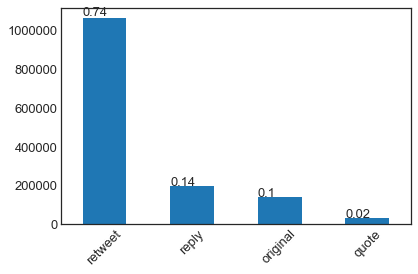

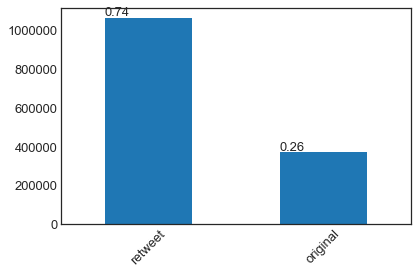

In [10]:
ax = df_cdc.tweet_type.value_counts().plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(round(p.get_height()/df_cdc.shape[0], 2)), (p.get_x() * 1, p.get_height() * 1.01))
plt.tight_layout()
plt.show()

ax = df_cdc.tweet_type_2.value_counts().plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(round(p.get_height()/df_cdc.shape[0], 2)), (p.get_x() * 1, p.get_height() * 1.01))
plt.tight_layout()
plt.show()

In [11]:
df_cdc.columns

Index(['date_only', 'favorite_count', 'hashtags', 'id',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'publish_date', 'retweet_count',
       'retweet_or_quote_id', 'retweet_or_quote_screen_name',
       'retweet_or_quote_user_id', 'sent_comp', 'text_mod', 'tweet_type',
       'tweet_type_2', 'tweet_url', 'urls', 'user_created_at',
       'user_followers_count', 'user_friends_count', 'user_id', 'user_name',
       'user_screen_name', 'user_statuses_count', 'user_verified',
       'datetime_EST', 'date_EST'],
      dtype='object')

In [12]:
df_cdc.head()

date_only  favorite_count     hashtags                   id  \
0  2020-01-21 00:00:00              11          NaN  1219746203652456448   
1  2020-01-21 00:00:00             375          NaN  1219746544955453441   
2  2020-01-21 00:00:00              81      DYK flu  1219746991850258437   
3  2020-01-21 00:00:00             150          NaN  1219747361473298434   
4  2020-01-21 00:00:00            1107  coronavirus  1219747786071007232   

  in_reply_to_screen_name  in_reply_to_status_id  in_reply_to_user_id  \
0                     NaN                    NaN                  NaN   
1                     NaN                    NaN                  NaN   
2                     NaN                    NaN                  NaN   
3                     NaN                    NaN                  NaN   
4                     NaN                    NaN                  NaN   

          publish_date  retweet_count  retweet_or_quote_id  ...  \
0  2020-01-21 22:18:51              6         1.219746e+18  ...   
1  2020-01-21 22:20:12             80         1.219725e+18  ...   
2  2020-01-21 22:21:59             85         1.217134e+18  ...   
3  2020-01-21 22:23:27            147         1.219694e+18  ...   
4  2020-01-21 22:25:08           1279         1.219726e+18  ...   

                  user_created_at  user_followers_count  user_friends_count  \
0  Sat Mar 03 03:29:43 +0000 2018                  4162                2385   
1  Thu Feb 11 18:02:01 +0000 2010                  1010                 370   
2  Mon Aug 12 20:30:07 +0000 2013                    52                  30   
3  Sun May 18 16:53:52 +0000 2014                  5340                4708   
4  Mon Apr 02 20:30:45 +0000 2012                  1061                2705   

              user_id            user_name user_screen_name  \
0  969776806860476416       🇺🇸FREED•ANON🇺🇸      FREEDANON17   
1           113418424             𝘼𝙠𝙝𝙞𝙡𝙚𝙨𝙝   AkhileshTekade   
2          1665971426                CRHPC            CRHPC   
3          2504981221                   TD          td21241   
4           543797013  Frida Romay Hidalgo    FridaRomayHgo   

  user_statuses_count user_verified               datetime_EST    date_EST  
0               88526         False  2020-01-21 17:18:51-05:00  2020-01-21  
1               89843         False  2020-01-21 17:20:12-05:00  2020-01-21  
2                1966         False  2020-01-21 17:21:59-05:00  2020-01-21  
3              282945         False  2020-01-21 17:23:27-05:00  2020-01-21  
4               10479         False  2020-01-21 17:25:08-05:00  2020-01-21  

[5 rows x 28 columns]

### Removing neutrals

In [13]:
# pd.set_option('display.max_colwidth', -1)
df_cdc_filtered = df_cdc[(df_cdc.sent_comp > 0.05) | (df_cdc.sent_comp < -0.05)]
df_cdc_filtered.shape
df_cdc_filtered.to_csv(FILTER_DIR + "cdc_neutrals_removed.csv", index=False)

In [14]:
num_removed = df_cdc.shape[0] - df_cdc_filtered.shape[0]
print('number of neutrals removed: ', num_removed)
print('fraction of tweets removed: ', num_removed/df_cdc.shape[0])

number of neutrals removed:  431045
fraction of tweets removed:  0.2999523327383624


In [15]:
# pd.set_option('display.max_colwidth', -1)
df_cdc_positive = df_cdc[df_cdc.sent_comp > 0.05]
print(df_cdc_positive.shape)

print('number of positives: ', df_cdc_positive.shape[0])
print('fraction of tweets that are positive: ', df_cdc_positive.shape[0]/df_cdc.shape[0])

(399511, 28)
number of positives:  399511
fraction of tweets that are positive:  0.278008691446684


In [16]:
# pd.set_option('display.max_colwidth', -1)
df_cdc_negative = df_cdc[df_cdc.sent_comp < -0.05]
print(df_cdc_negative.shape)

print('number of negative: ', df_cdc_negative.shape[0])
print('fraction of tweets that are negative: ', df_cdc_negative.shape[0]/df_cdc.shape[0])

(606489, 28)
number of negative:  606489
fraction of tweets that are negative:  0.4220389758149536


## Summary for today:

#### 1. Removing neutrals just makes the peaks more extreme, this is not unexpected. 
#### 2. Instead, if we look at positive / negative sentiment seprately we can see increased sentiment polarity.
#### 3. RTs seem to be driving this?

# 1. CDC Plots

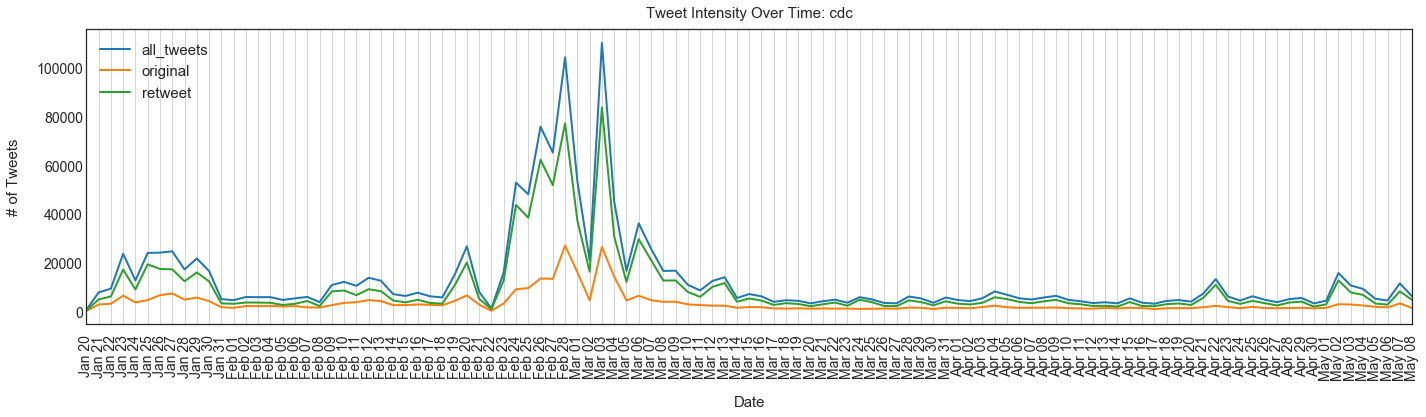

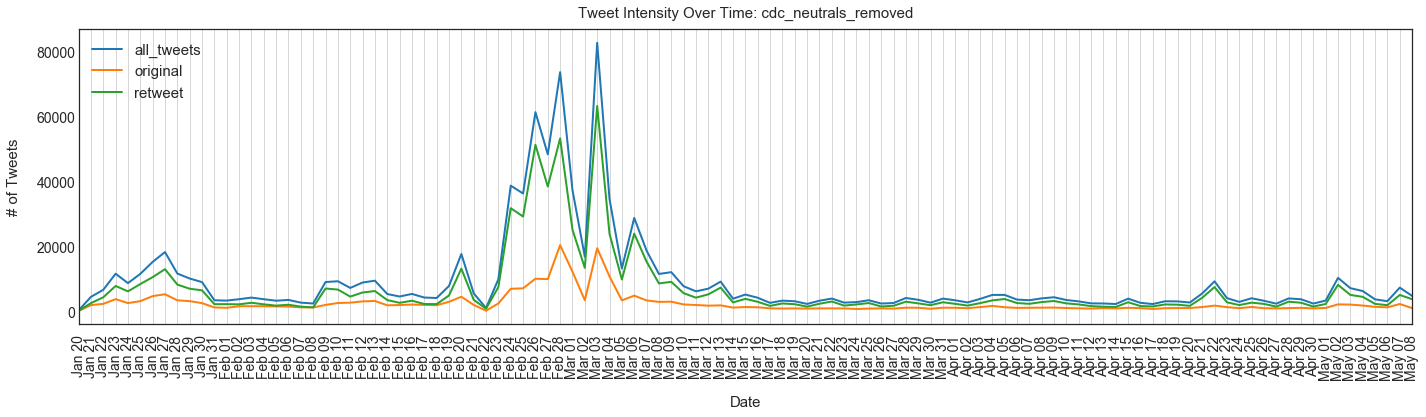

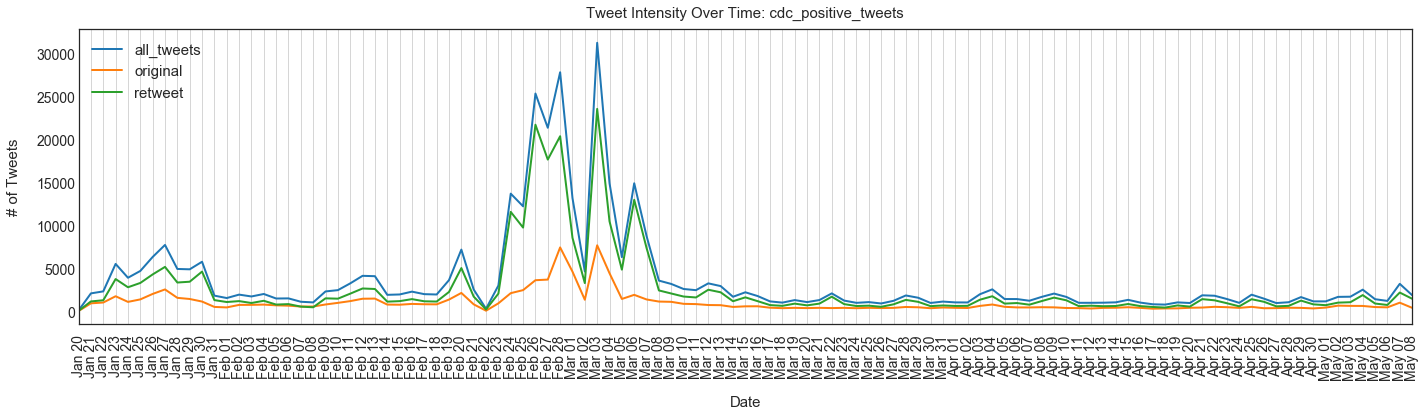

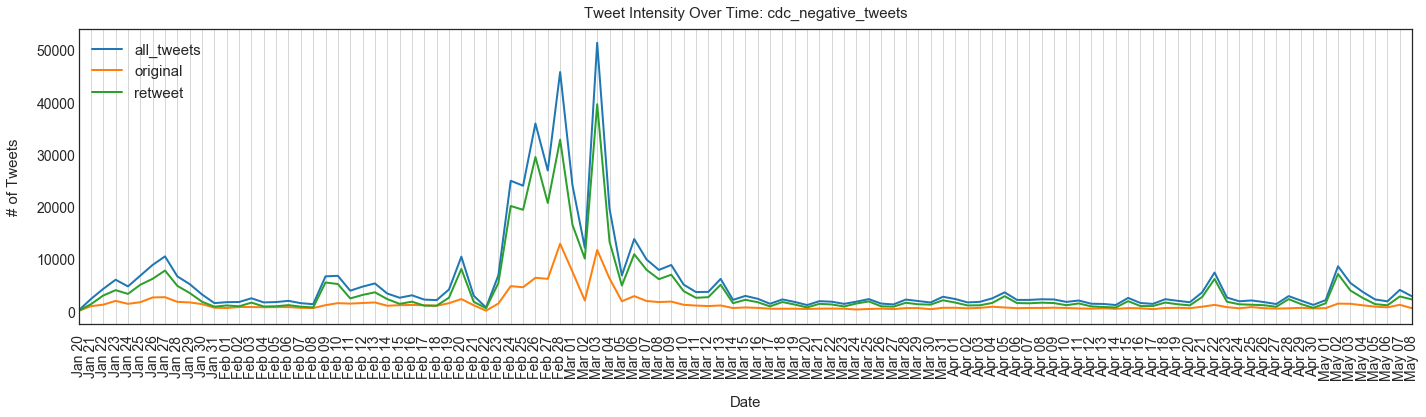

In [476]:
intensity_plots(df_cdc, 'date_EST', 'tweet_type_2', 'cdc')
intensity_plots(df_cdc_filtered, 'date_EST', 'tweet_type_2', 'cdc_neutrals_removed')
intensity_plots(df_cdc_positive, 'date_EST', 'tweet_type_2', 'cdc_positive_tweets')
intensity_plots(df_cdc_negative, 'date_EST', 'tweet_type_2', 'cdc_negative_tweets')

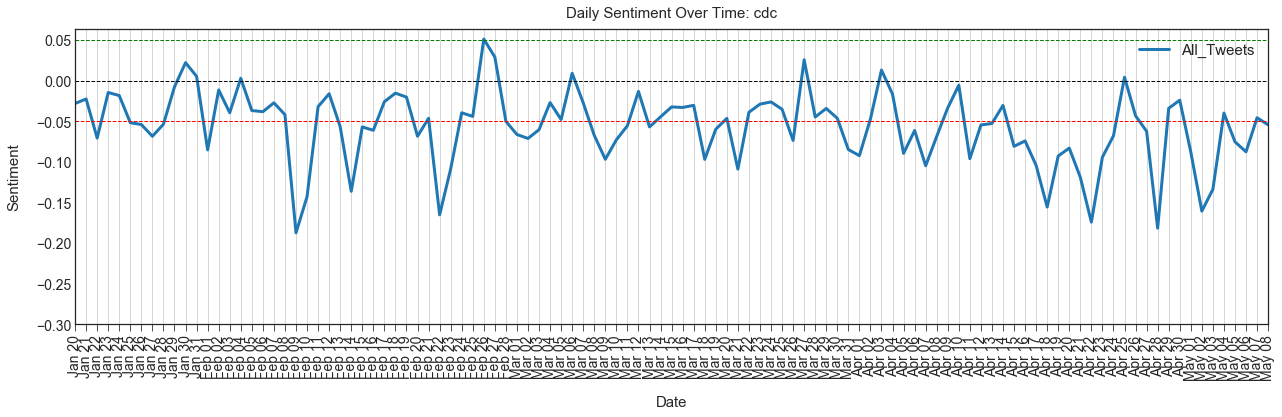

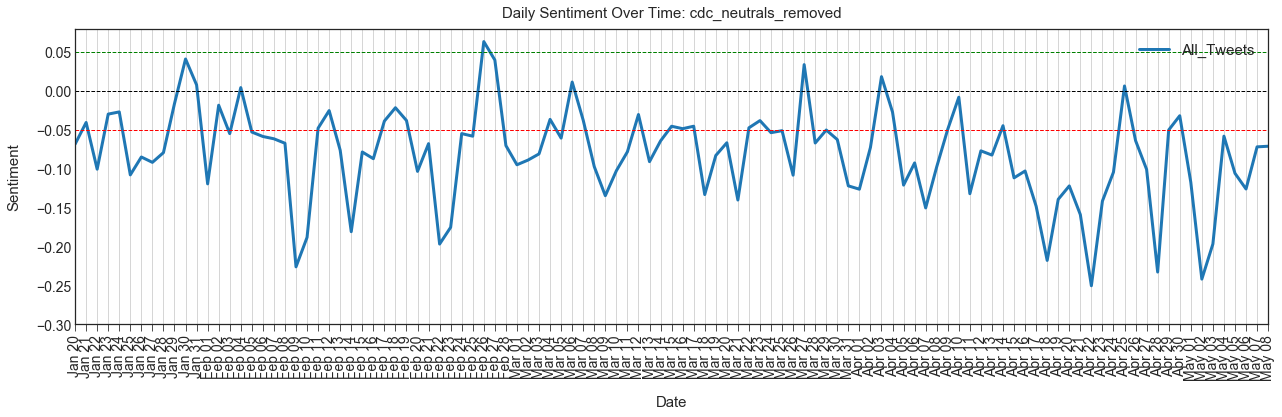

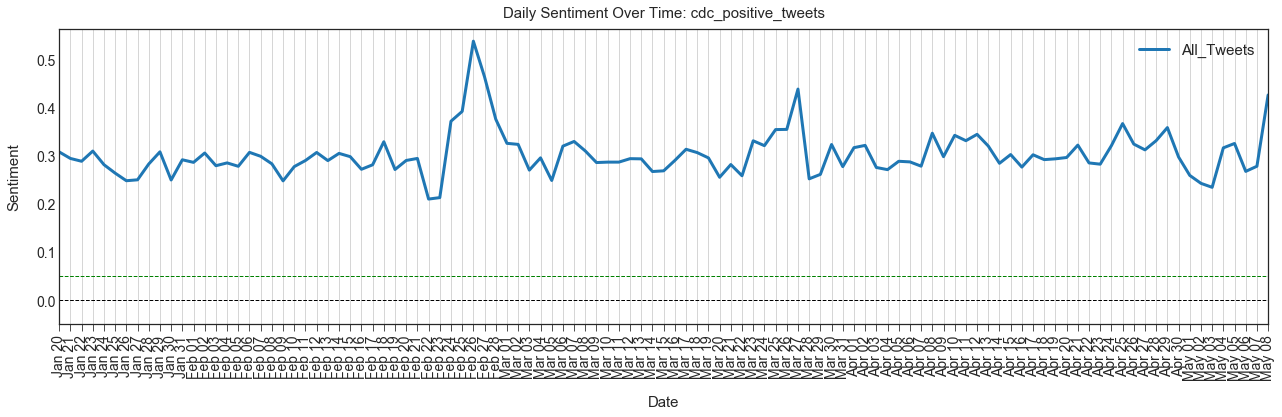

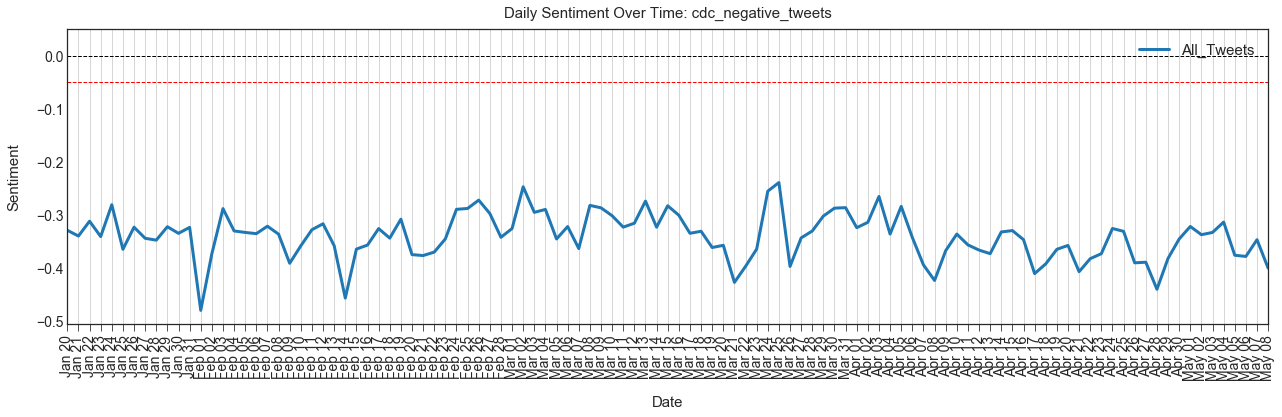

In [318]:
sentiment_plots(df_cdc, 'date_EST', 'tweet_type_2', 'cdc')
sentiment_plots(df_cdc_filtered, 'date_EST', 'tweet_type_2', 'cdc_neutrals_removed')
sentiment_plots(df_cdc_positive, 'date_EST', 'tweet_type_2', 'cdc_positive_tweets')
sentiment_plots(df_cdc_negative, 'date_EST', 'tweet_type_2', 'cdc_negative_tweets')

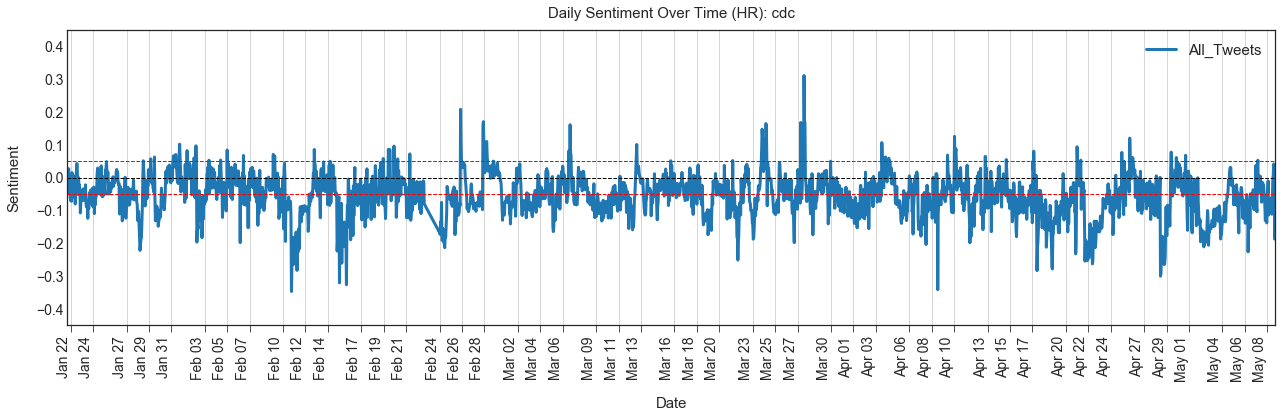

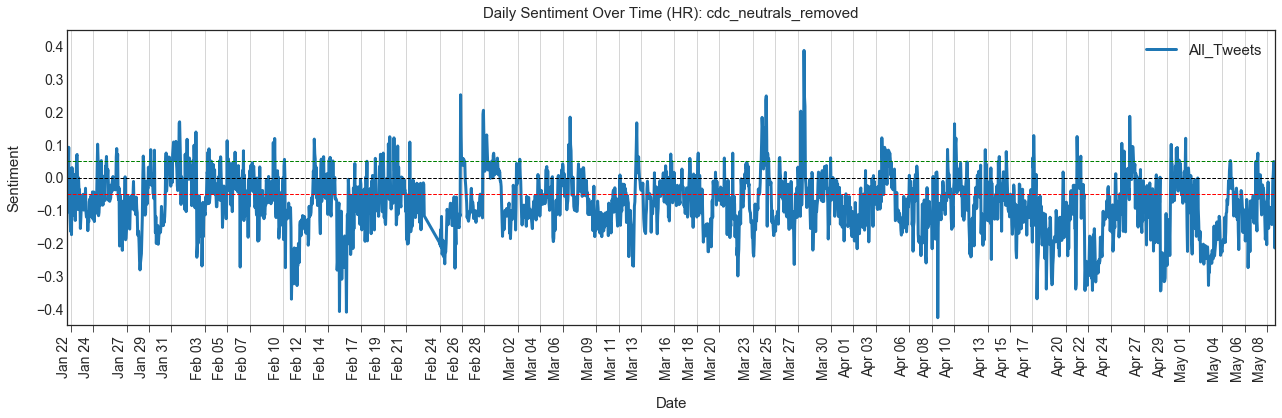

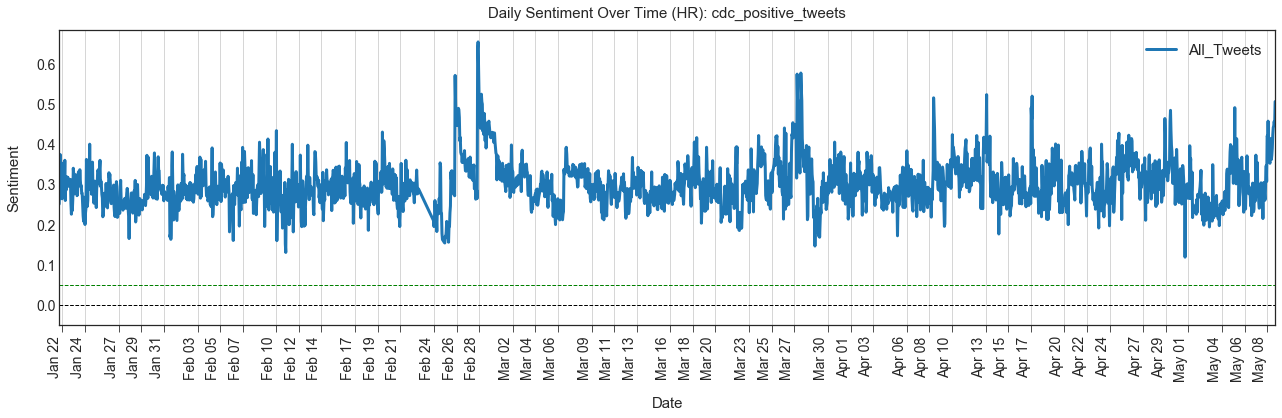

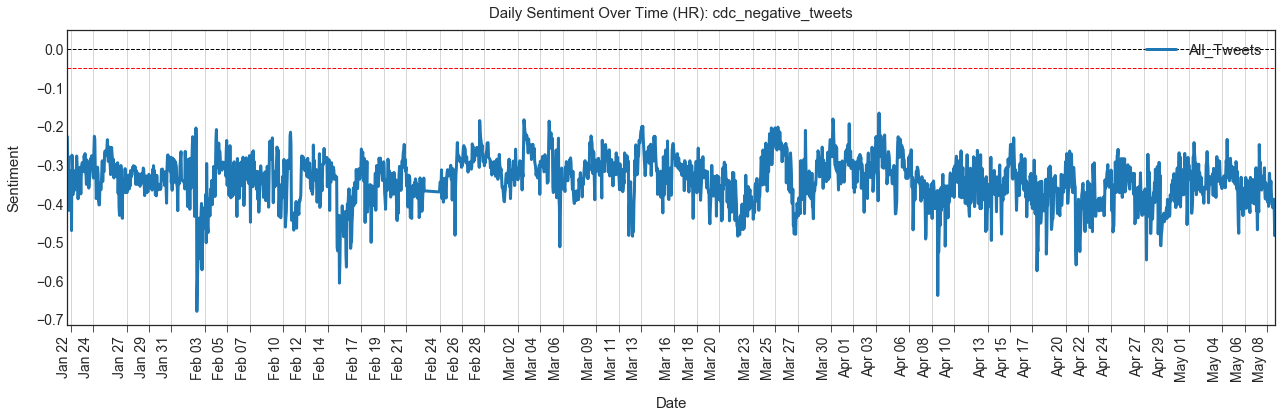

In [470]:
sentiment_plots(df_cdc, 'date_hr_EST_final', 'tweet_type_2', 'cdc', timescale=True)
sentiment_plots(df_cdc_filtered, 'date_hr_EST_final', 'tweet_type_2', 'cdc_neutrals_removed', timescale=True)
sentiment_plots(df_cdc_positive, 'date_hr_EST_final', 'tweet_type_2', 'cdc_positive_tweets', timescale=True)
sentiment_plots(df_cdc_negative, 'date_hr_EST_final', 'tweet_type_2', 'cdc_negative_tweets', timescale=True)

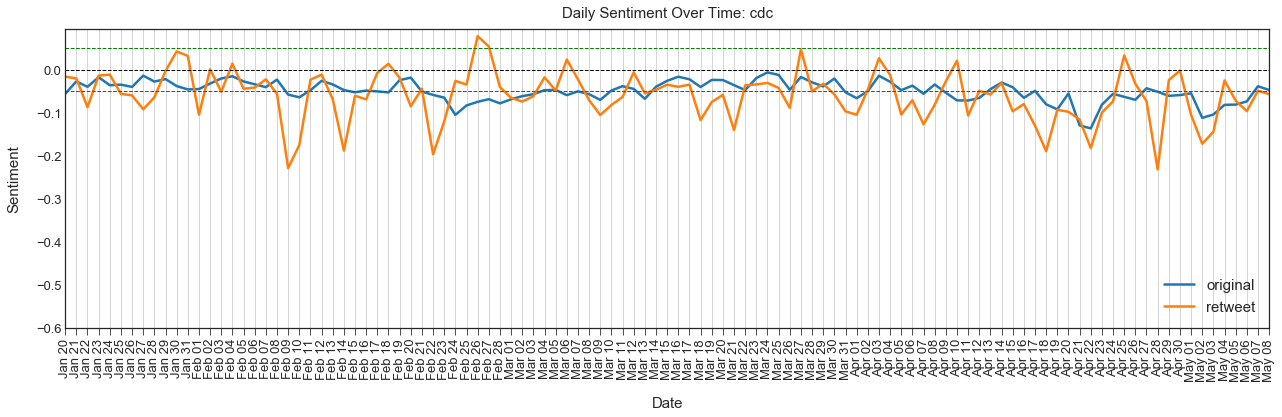

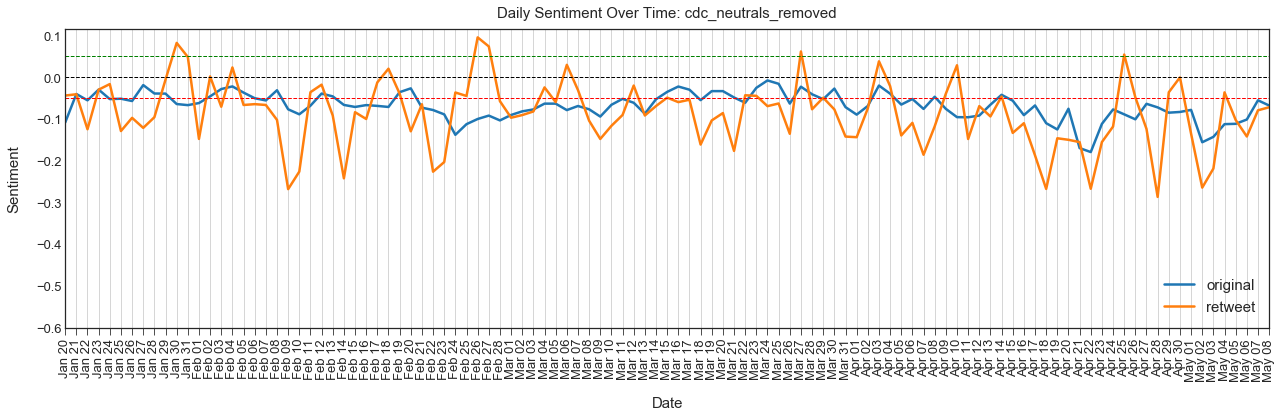

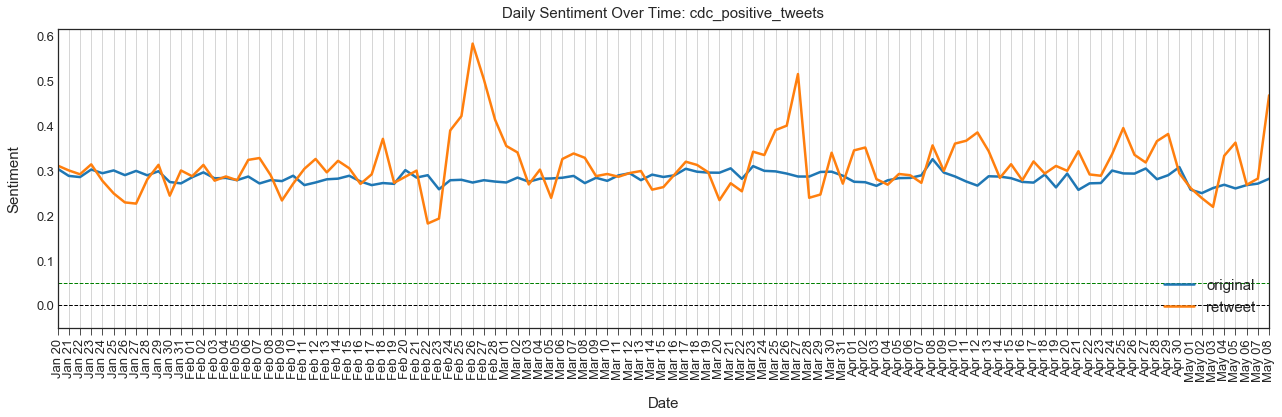

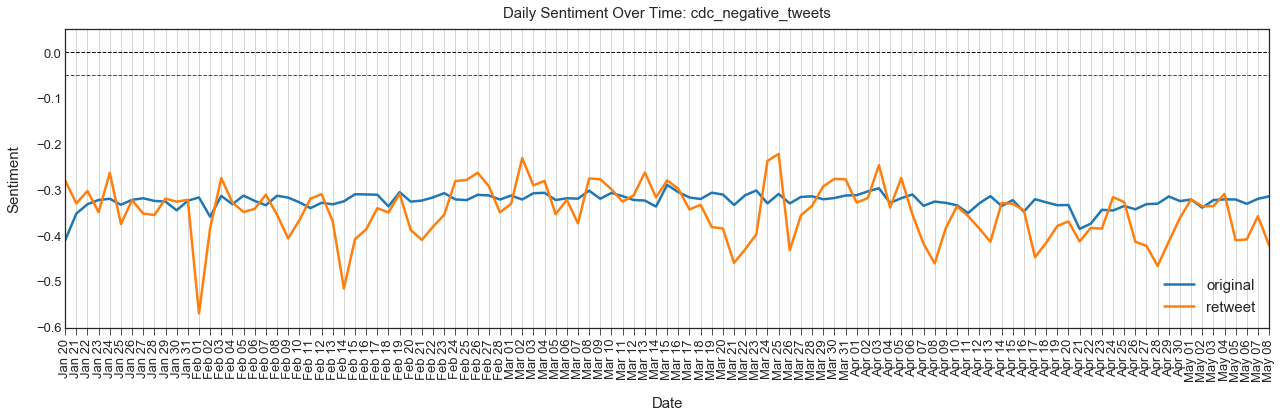

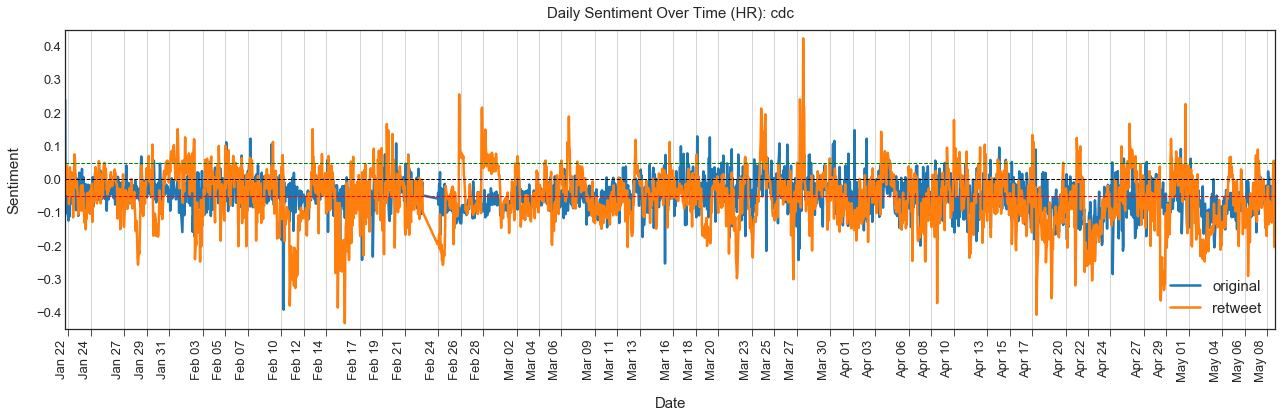

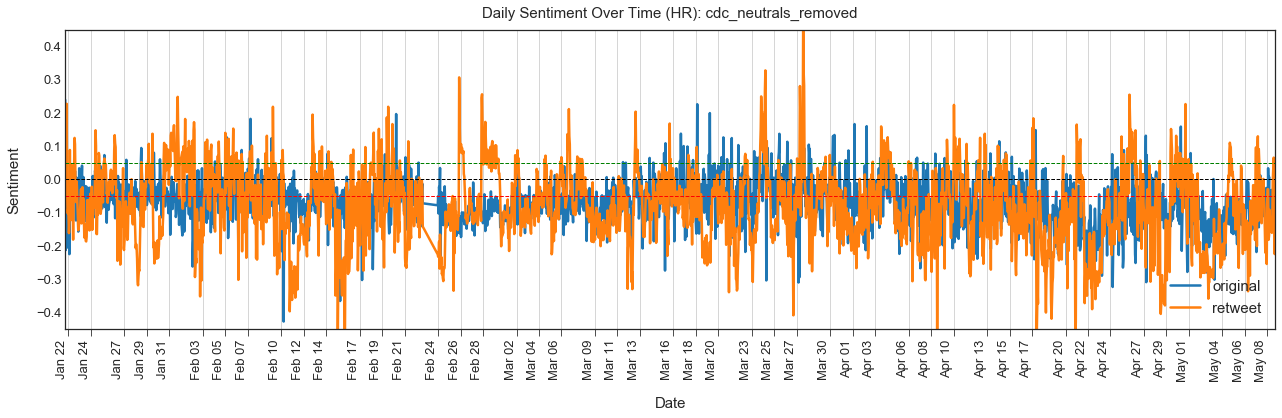

In [352]:
sentiment_plots_tweettype(df_cdc, 'date_EST', 'tweet_type_2', 'cdc')
sentiment_plots_tweettype(df_cdc_filtered, 'date_EST', 'tweet_type_2', 'cdc_neutrals_removed')
sentiment_plots_tweettype(df_cdc_positive, 'date_EST', 'tweet_type_2', 'cdc_positive_tweets')
sentiment_plots_tweettype(df_cdc_negative, 'date_EST', 'tweet_type_2', 'cdc_negative_tweets')

sentiment_plots_tweettype(df_cdc, 'date_hr_EST_final', 'tweet_type_2', 'cdc', timescale=True)
sentiment_plots_tweettype(df_cdc_filtered, 'date_hr_EST_final', 'tweet_type_2', 'cdc_neutrals_removed', timescale=True)

# 2. Moving Average Plots - (CDC and CDC+mask)

In [483]:
def get_daily_rolling(df_days, r_val='7d'):
    newdf = df_days.groupby('date_EST', as_index = False)['sent_comp'].count()
    newdf.set_index('date_EST', inplace=True)
    newdf.columns = ['sent_count']
    newdf['sent_sum'] = df_days.groupby('date_EST')['sent_comp'].sum()

    newdf['rolling_count_sum'] = newdf['sent_count'].rolling(r_val).sum()
    newdf['rolling_sent_sum'] = newdf['sent_sum'].rolling(r_val).sum()
    
    newdf['daily_rolling_sentiment'] = newdf['rolling_sent_sum']/newdf['rolling_count_sum']
    newdf = newdf[['daily_rolling_sentiment']]
    return newdf

In [493]:
def get_daily_rollingavg_plots(timeperiods, df_dailyavg):
    df_dailyavg_2 = df_dailyavg.copy()
    df_dailyavg_2.set_index('date_EST', inplace=True)
    for i in timeperiods:
        df_dailyrolling = get_daily_rolling(df_sent_daily, r_val=i)
        mergedDf = df_dailyavg_2.merge(df_dailyrolling, left_index=True, right_index=True)

        linewidths = [2, 3]
        styles = ['--','-']
        fig, ax = plt.subplots(figsize=(18, 6))
        for col, style, lw in zip(mergedDf.columns, styles, linewidths):
            mergedDf[col].plot(style=style, lw=lw, ax=ax, rot=90)

        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.legend(loc=1, prop={'size': 15})
        plt.title("Daily Moving Avg Timeperiod: " + str(i), y=1.02, fontsize=15)
        plt.show()

## A. CDC - Daily Moving Avg

In [485]:
df_sent_dailyavg = pd.read_csv(SENTIMENT_DIR + "cdc_sentiment_data.csv")
df_sent_dailyavg['date_EST'] = pd.to_datetime(df_sent_dailyavg['date_EST'])
# df_sent_dailyavg.set_index('date_EST', inplace=True)
df_sent_dailyavg.columns = ['date_EST','sent_comp']
df_sent_dailyavg.shape

(109, 2)

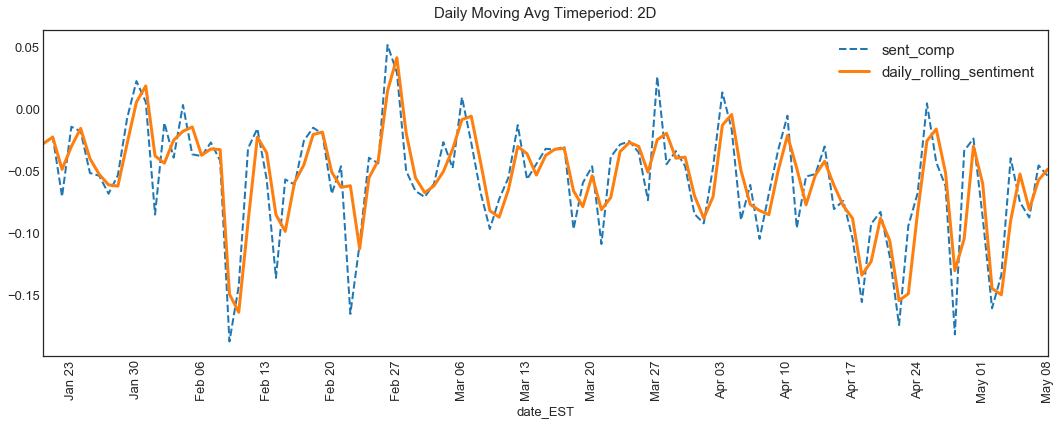

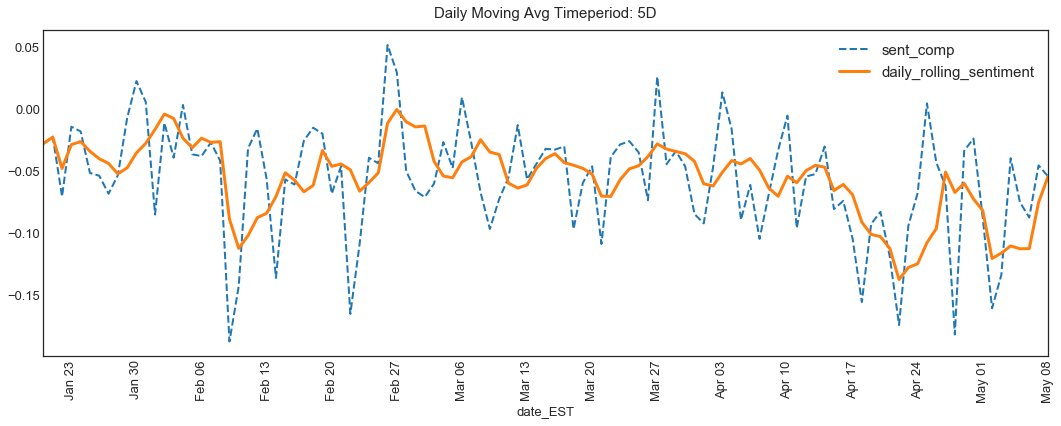

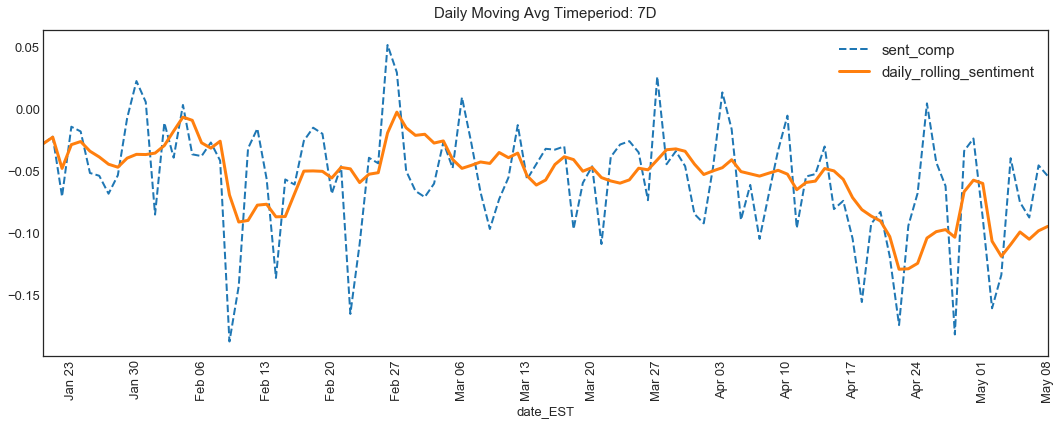

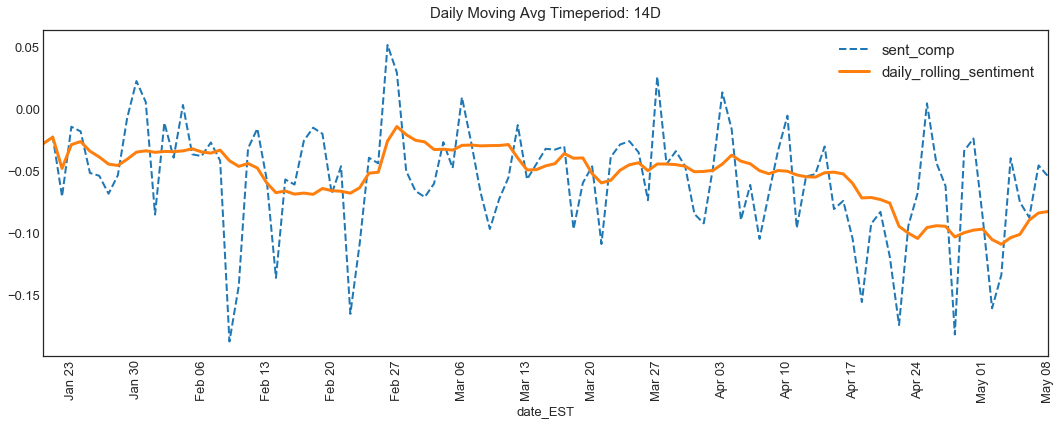

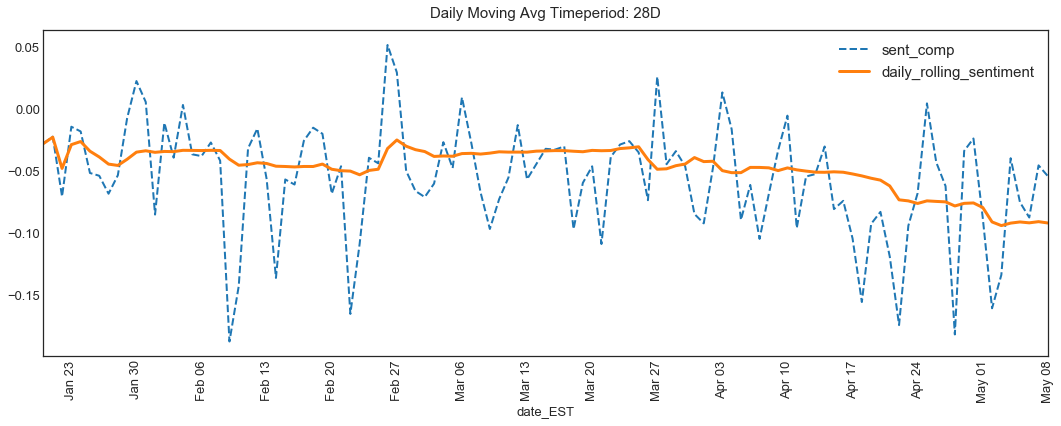

In [487]:
get_daily_rollingavg_plots(['2D', '5D', '7D', '14D', '28D'], df_sent_dailyavg)

## B. CDC - Daily Moving Avg (Neutrals Removed)

In [494]:
df_sent_dailyavg = pd.read_csv(SENTIMENT_DIR + "cdc_neutrals_removed_sentiment_data.csv")
df_sent_dailyavg['date_EST'] = pd.to_datetime(df_sent_dailyavg['date_EST'])
# df_sent_dailyavg.set_index('date_EST', inplace=True)
# df_sent_dailyavg.columns = ['daily_avg_sentiment']
df_sent_dailyavg.columns = ['date_EST','sent_comp']


df_sent_dailyavg.shape

(109, 2)

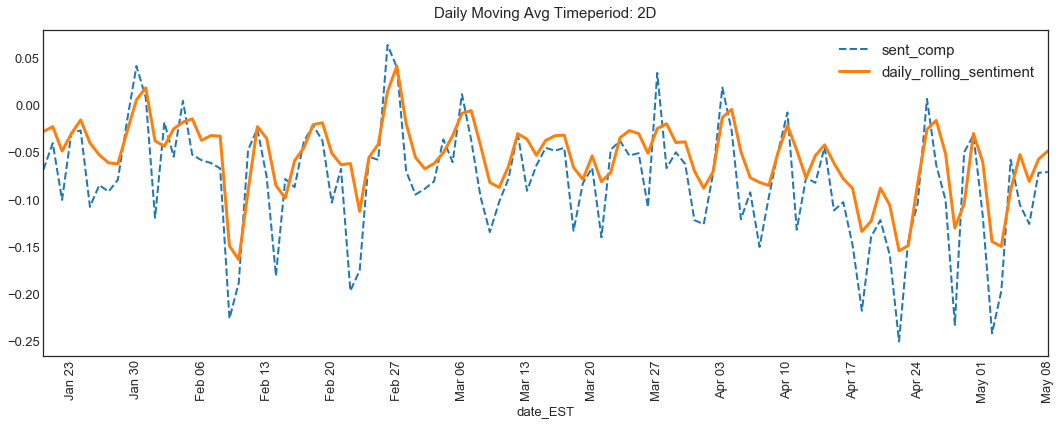

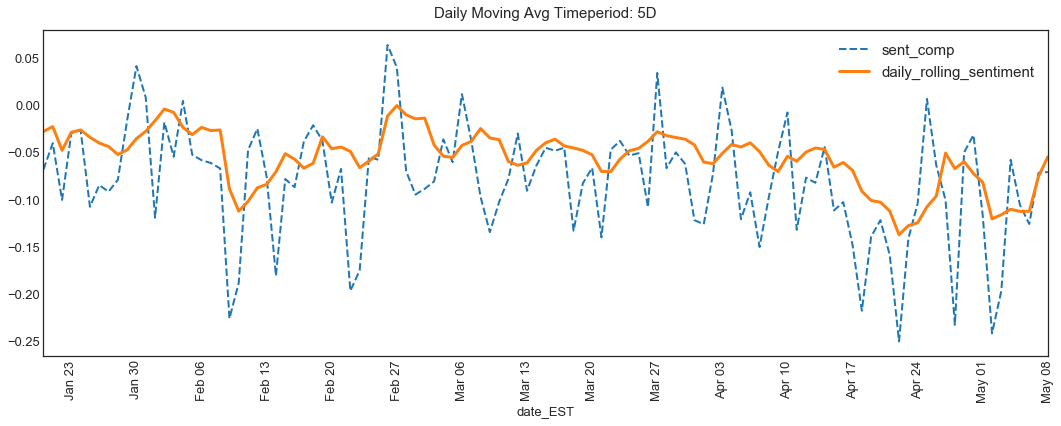

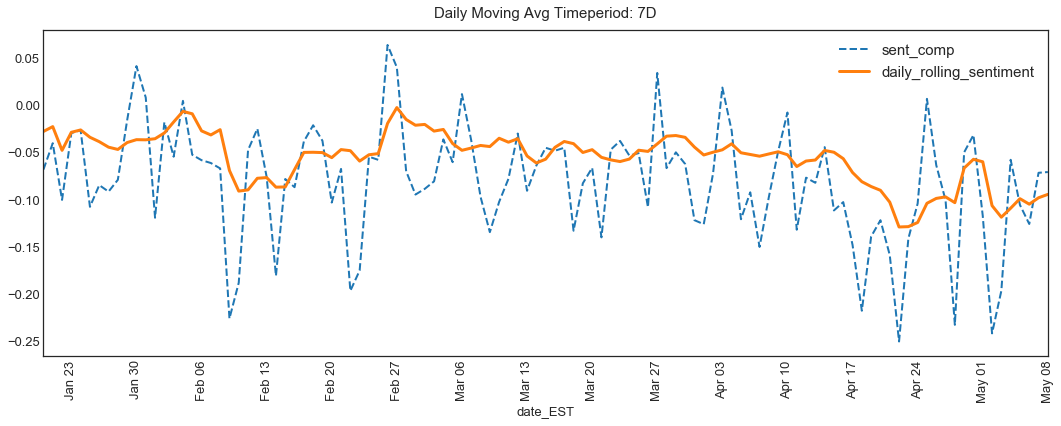

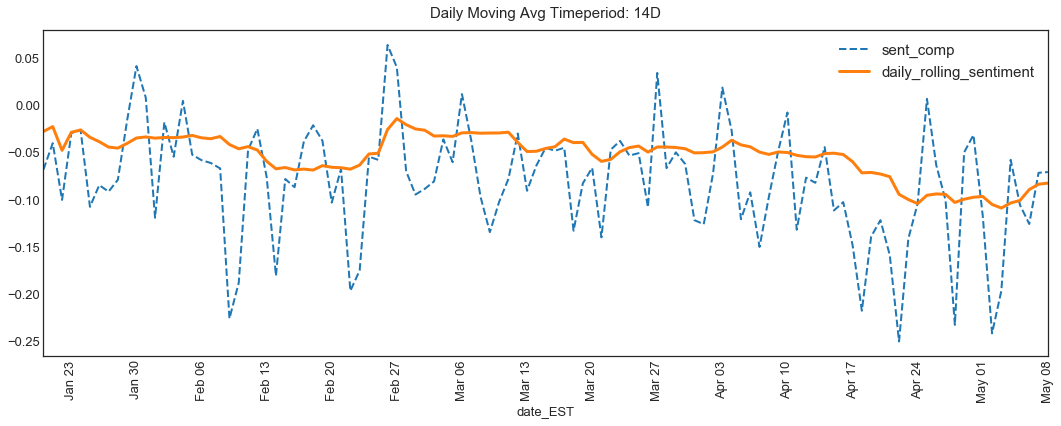

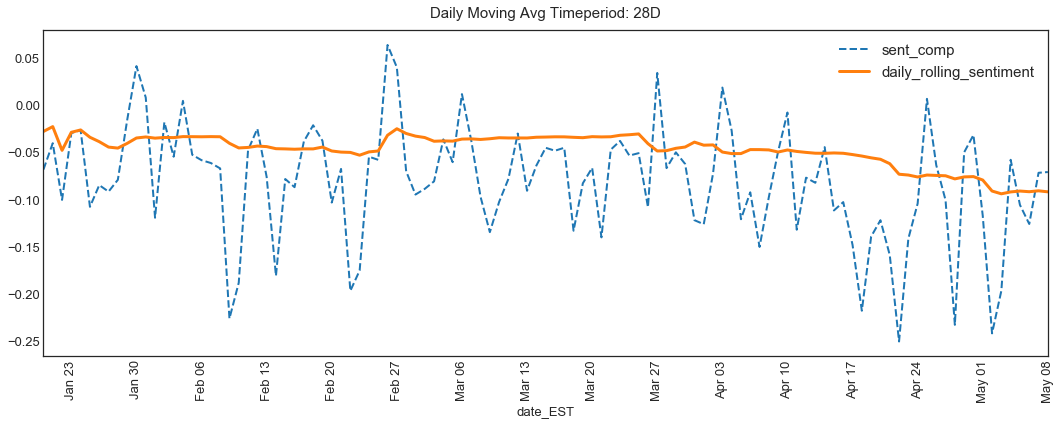

In [495]:
get_daily_rollingavg_plots(['2D', '5D', '7D', '14D', '28D'], df_sent_dailyavg)

## C. CDC + MASK - Daily Moving Avg 

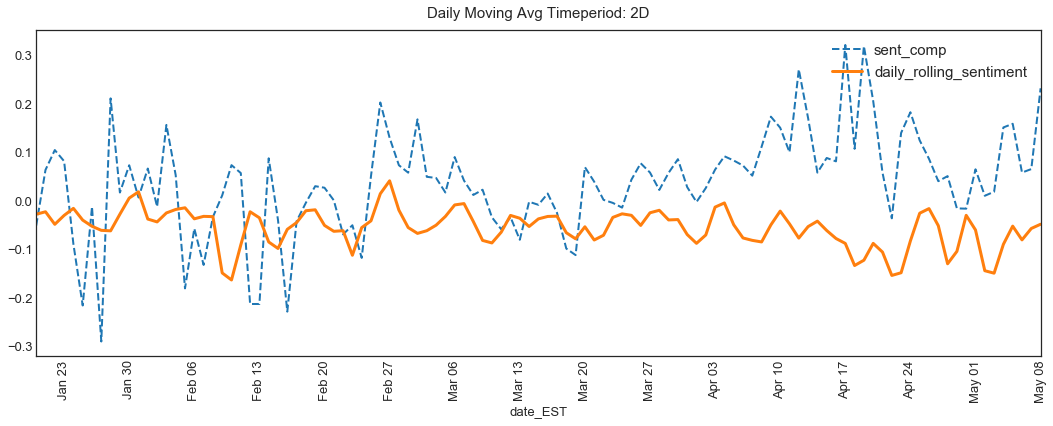

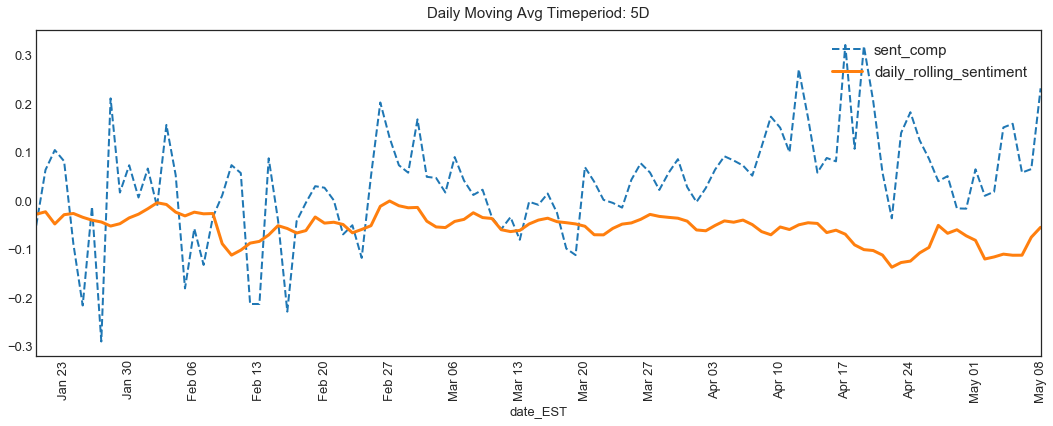

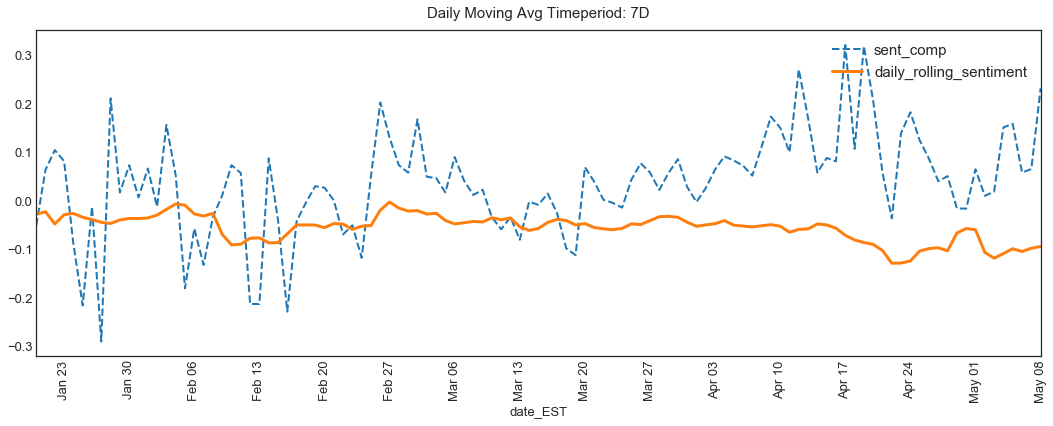

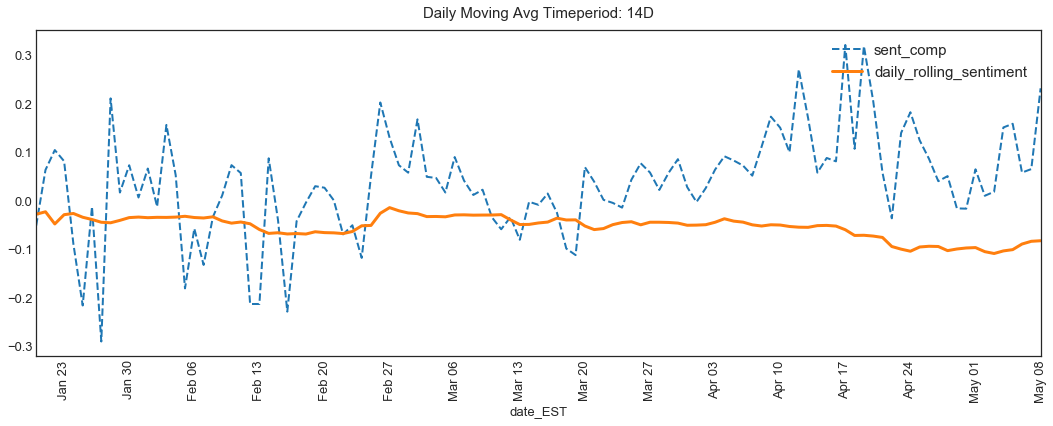

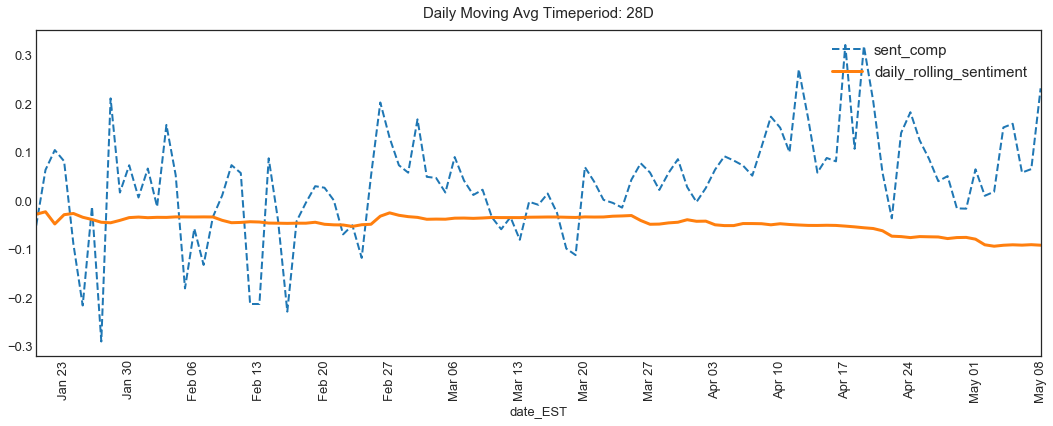

In [500]:
df_sent_dailyavg = pd.read_csv(SENTIMENT_DIR + "cdc_mask_sentiment_data.csv")
df_sent_dailyavg['date_EST'] = pd.to_datetime(df_sent_dailyavg['date_EST'])
# df_sent_dailyavg.set_index('date_EST', inplace=True)
# df_sent_dailyavg.columns = ['daily_avg_sentiment']
# df_sent_dailyavg.shape
df_sent_dailyavg.columns = ['date_EST','sent_comp']

# print(df_sent_dailyavg)

get_daily_rollingavg_plots(['2D', '5D', '7D', '14D', '28D'], df_sent_dailyavg)

## D. CDC + MASKS - Daily Moving Avg (Neutrals Removed) 

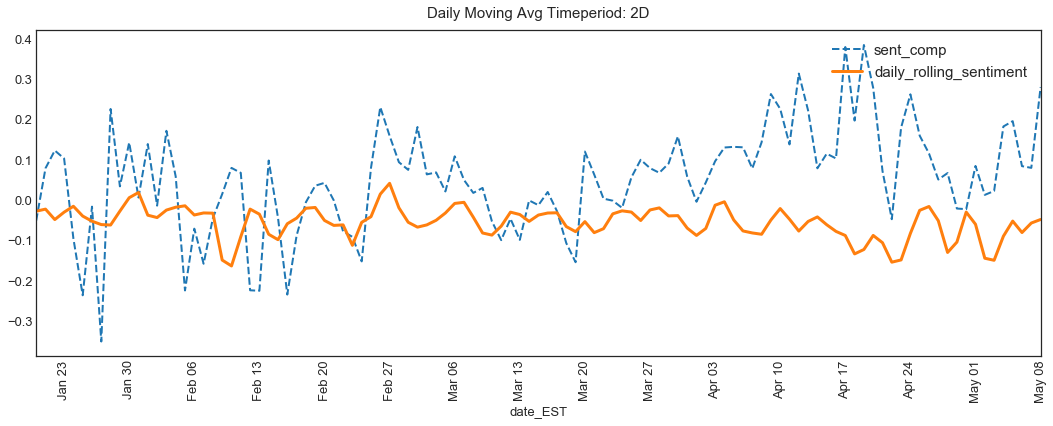

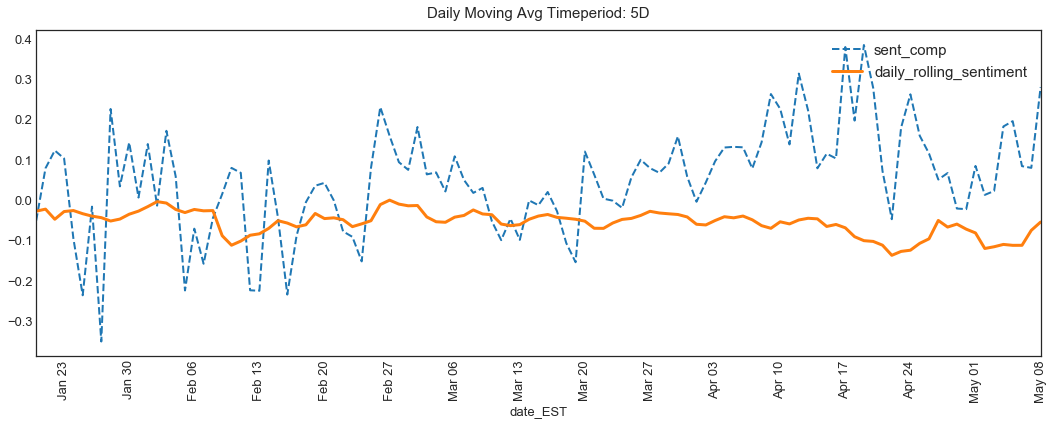

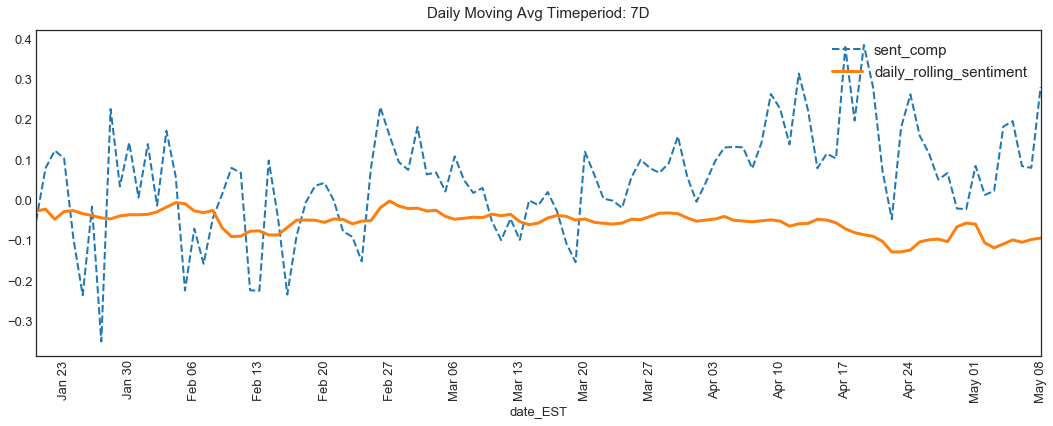

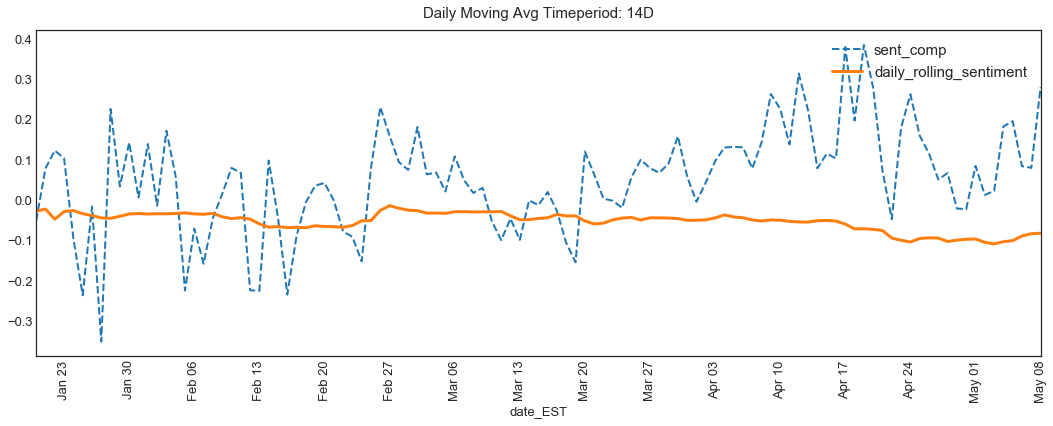

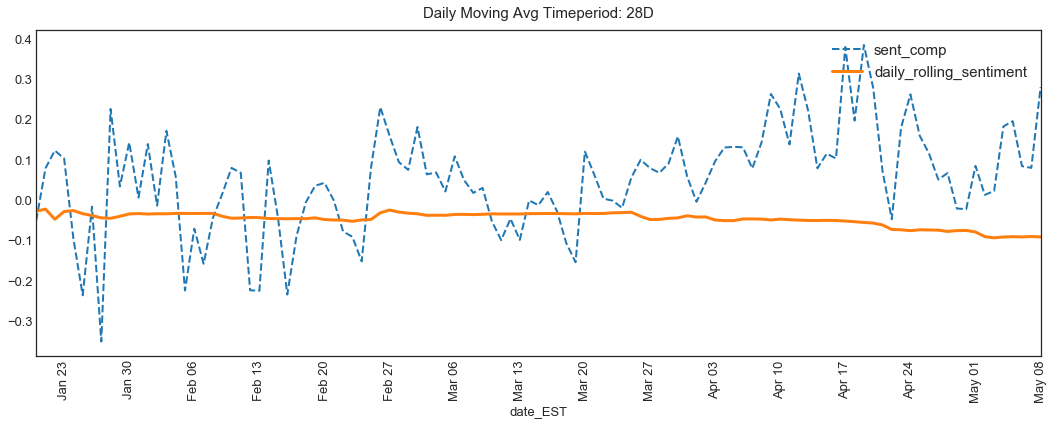

In [501]:
df_sent_dailyavg = pd.read_csv(SENTIMENT_DIR + "cdc_mask_neutrals_removed_sentiment_data.csv")
df_sent_dailyavg['date_EST'] = pd.to_datetime(df_sent_dailyavg['date_EST'])
# df_sent_dailyavg.set_index('date_EST', inplace=True)
# df_sent_dailyavg.columns = ['daily_avg_sentiment']
# df_sent_dailyavg.shape
df_sent_dailyavg.columns = ['date_EST','sent_comp']



get_daily_rollingavg_plots(['2D', '5D', '7D', '14D', '28D'], df_sent_dailyavg)

## SANDBOX

### AVG Daily  Sentiment - Rolling

In [454]:
def get_AVGdaily_rollingavg_plots(timeperiods, df_dailyavg):
    for i in timeperiods:
        df_dailyrolling = df_dailyavg.rolling(i).mean()
        df_dailyrolling.columns = ['AVGdaily_rolling_sentiment']
        mergedDf = df_dailyavg.merge(df_dailyrolling, left_index=True, right_index=True)

        linewidths = [2, 3]
        styles = ['--','-']
        fig, ax = plt.subplots(figsize=(18, 6))
        for col, style, lw in zip(mergedDf.columns, styles, linewidths):
            mergedDf[col].plot(style=style, lw=lw, ax=ax, rot=90)

        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.legend(loc=1, prop={'size': 15})
        plt.title("Daily Moving Avg Timeperiod: " + str(i), y=1.02, fontsize=15)
        plt.show()

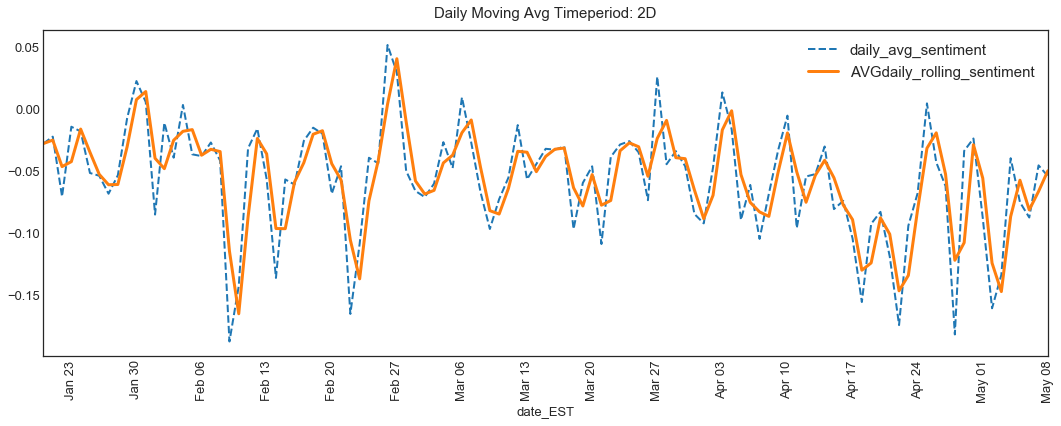

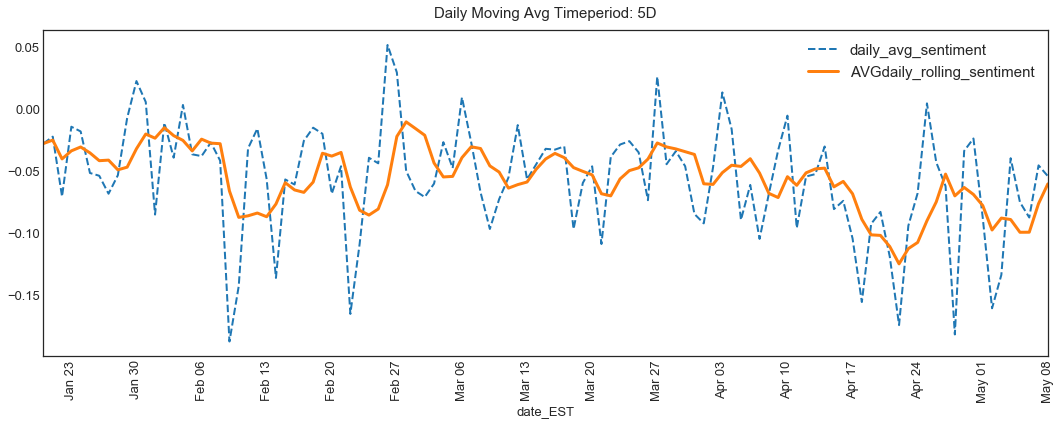

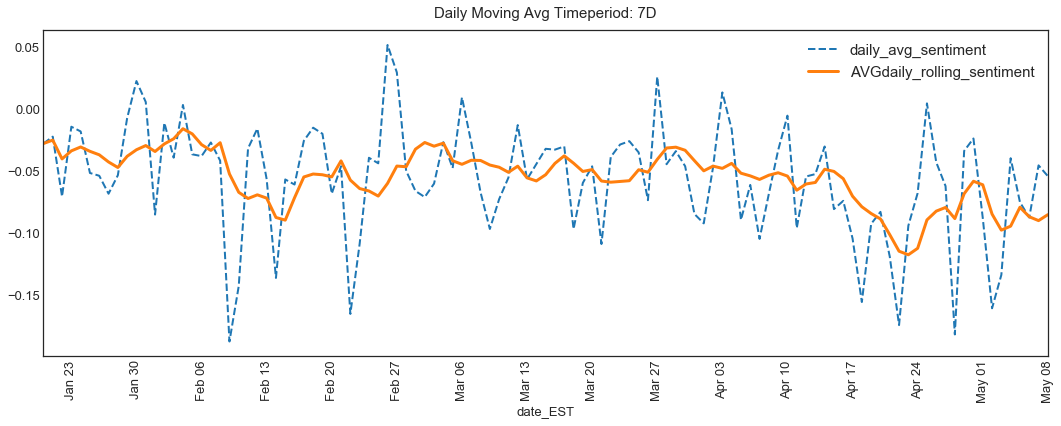

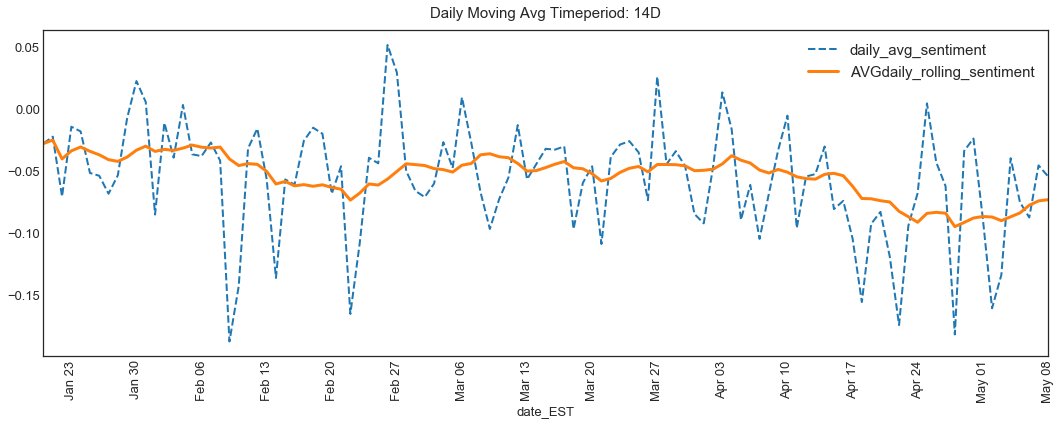

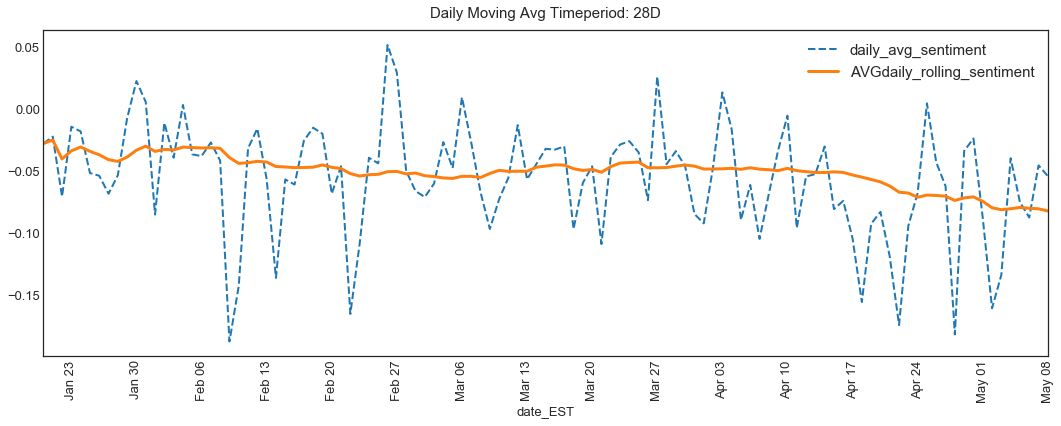

In [457]:
get_AVGdaily_rollingavg_plots(['2D', '5D', '7D', '14D', '28D'], df_sent_dailyavg)

# 2. Comparing CDC to other PHO's

In [17]:
df_cdc_intensity = pd.read_csv(INTENSITY_DIR + "cdc_intensity_data.csv")
df_niaid_intensity = pd.read_csv(INTENSITY_DIR + "niaid_intensity_data.csv")
df_nih_intensity = pd.read_csv(INTENSITY_DIR + "nih_intensity_data.csv")
df_hhs_intensity = pd.read_csv(INTENSITY_DIR + "hhs_intensity_data.csv")

pho_intensity_names = ['cdc', 'niaid', 'nih', 'hhs']
pho_intensity_list = [df_cdc_intensity, df_niaid_intensity, df_nih_intensity, df_hhs_intensity]
# get_shape(pho_intensity_list)


df_cdc_sentiment = pd.read_csv(SENTIMENT_DIR + "cdc_sentiment_data.csv")
df_niaid_sentiment = pd.read_csv(SENTIMENT_DIR + "niaid_sentiment_data.csv")
df_nih_sentiment = pd.read_csv(SENTIMENT_DIR + "nih_sentiment_data.csv")
df_hhs_sentiment = pd.read_csv(SENTIMENT_DIR + "hhs_sentiment_data.csv")

pho_sentiment_names = ['cdc', 'niaid', 'nih', 'hhs']
pho_sentiment_list = [df_cdc_sentiment, df_niaid_sentiment, df_nih_sentiment, df_hhs_sentiment]

In [18]:
df_pho_intensity = merge_dfs(pho_intensity_list)
df_pho_intensity.fillna(0,  inplace=True)
pho_intensity_cols = get_col_name(pho_intensity_names)
df_pho_intensity.columns = pho_intensity_cols
print(df_pho_intensity.shape)

df_pho_sentiment = merge_dfs(pho_sentiment_list)
df_pho_sentiment.fillna(0,  inplace=True)
df_pho_sentiment.columns = ['date_EST'] + pho_sentiment_names
print(df_pho_sentiment.shape)

(109, 13)
(109, 5)


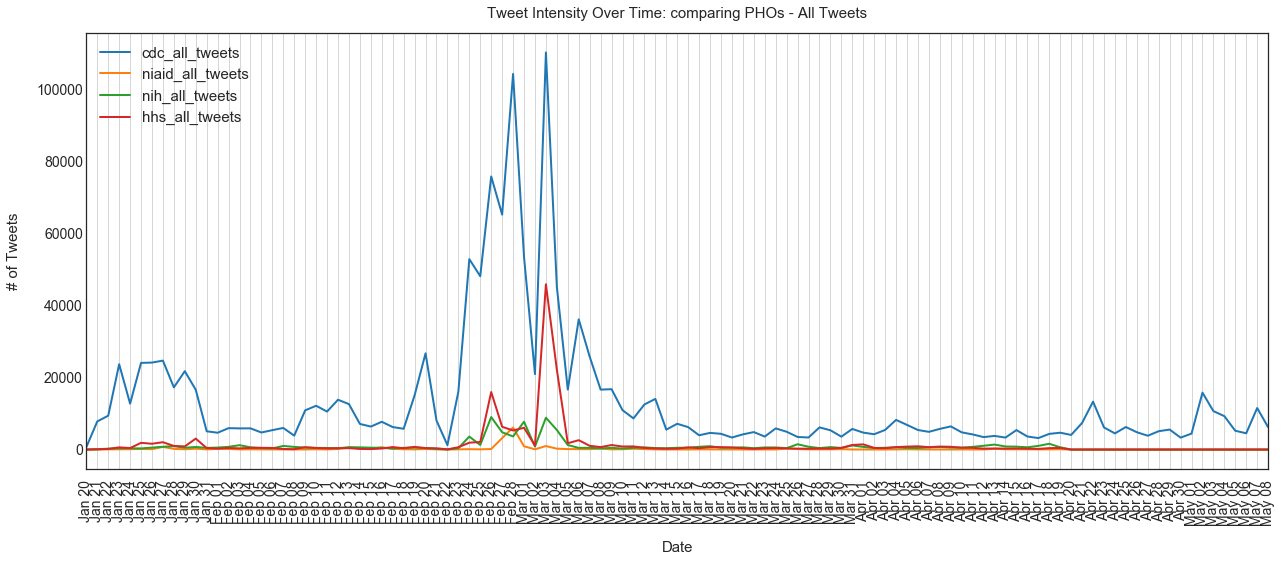

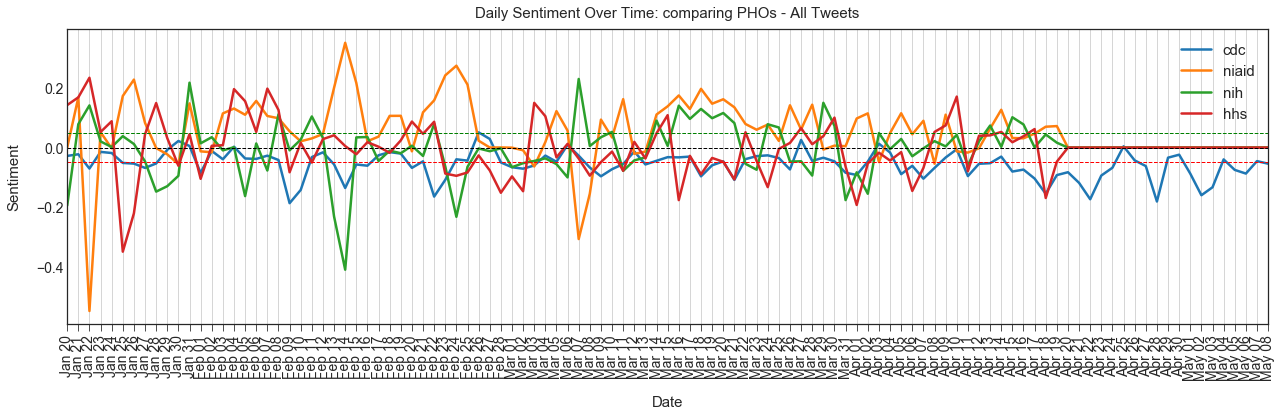

In [19]:
get_comparison_plot(df_pho_intensity, df_pho_sentiment, 'comparing PHOs - All Tweets')

# 3. Comparing all individuals

In [25]:
df_fauci_intensity = pd.read_csv(INTENSITY_DIR + "fauci_intensity_data.csv")
df_collins_intensity = pd.read_csv(INTENSITY_DIR + "collins_intensity_data.csv")
df_redfield_intensity = pd.read_csv(INTENSITY_DIR + "redfield_intensity_data.csv")
df_azar_intensity = pd.read_csv(INTENSITY_DIR + "azar_intensity_data.csv")
df_birx_intensity = pd.read_csv(INTENSITY_DIR + "birx_intensity_data.csv")
df_surgeongeneral_intensity = pd.read_csv(INTENSITY_DIR + "surgeongeneral_intensity_data.csv")
df_trump_intensity = pd.read_csv(INTENSITY_DIR + "trump_intensity_data.csv")
df_pence_intensity = pd.read_csv(INTENSITY_DIR + "pence_intensity_data.csv")
df_whitehouse_intensity = pd.read_csv(INTENSITY_DIR + "whitehouse_intensity_data.csv")

names_intensity_names = ['fauci', 'collins', 'redfield', 'azar', 'birx', 'surgeongeneral', 'trump', 
                       'pence', 'whitehouse']
names_intensity_list = [df_fauci_intensity, df_collins_intensity, df_redfield_intensity, df_azar_intensity, 
                      df_birx_intensity, df_surgeongeneral_intensity, df_trump_intensity, df_pence_intensity, 
                      df_whitehouse_intensity]

df_fauci_sentiment = pd.read_csv(SENTIMENT_DIR + "fauci_sentiment_data.csv")
df_collins_sentiment = pd.read_csv(SENTIMENT_DIR + "collins_sentiment_data.csv")
df_redfield_sentiment = pd.read_csv(SENTIMENT_DIR + "redfield_sentiment_data.csv")
df_azar_sentiment = pd.read_csv(SENTIMENT_DIR + "azar_sentiment_data.csv")
df_birx_sentiment = pd.read_csv(SENTIMENT_DIR + "birx_sentiment_data.csv")
df_surgeongeneral_sentiment = pd.read_csv(SENTIMENT_DIR + "surgeongeneral_sentiment_data.csv")
df_trump_sentiment = pd.read_csv(SENTIMENT_DIR + "trump_sentiment_data.csv")
df_pence_sentiment = pd.read_csv(SENTIMENT_DIR + "pence_sentiment_data.csv")
df_whitehouse_sentiment = pd.read_csv(SENTIMENT_DIR + "whitehouse_sentiment_data.csv")

names_sentiment_names = ['fauci', 'collins', 'redfield', 'azar', 'birx', 'surgeongeneral', 'trump', 
                       'pence', 'whitehouse']
names_sentiment_list = [df_fauci_sentiment, df_collins_sentiment, df_redfield_sentiment, df_azar_sentiment, 
                      df_birx_sentiment, df_surgeongeneral_sentiment, df_trump_sentiment, df_pence_sentiment, 
                      df_whitehouse_sentiment]

In [26]:
df_names_intensity = merge_dfs(names_intensity_list)
df_names_intensity.fillna(0,  inplace=True)
names_intensity_cols = get_col_name(names_intensity_names)
df_names_intensity.columns = names_intensity_cols
print(df_names_intensity.shape)

df_names_sentiment = merge_dfs(names_sentiment_list)
df_names_sentiment.fillna(0,  inplace=True)
df_names_sentiment.columns = ['date_EST'] + names_sentiment_names
print(df_names_sentiment.shape)

(89, 28)
(89, 10)


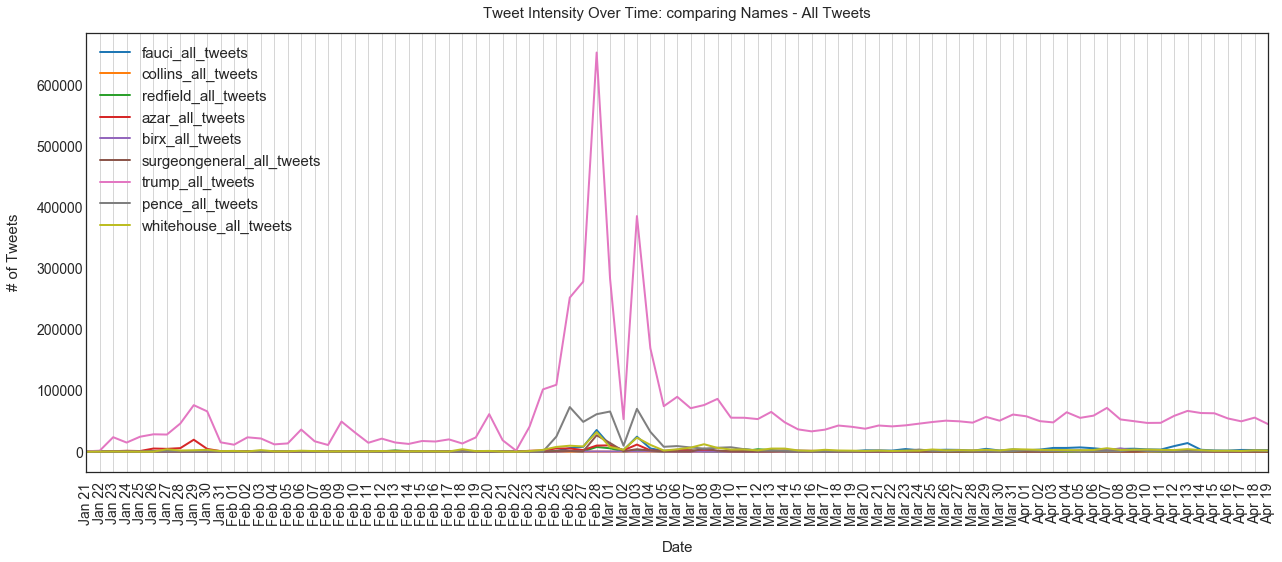

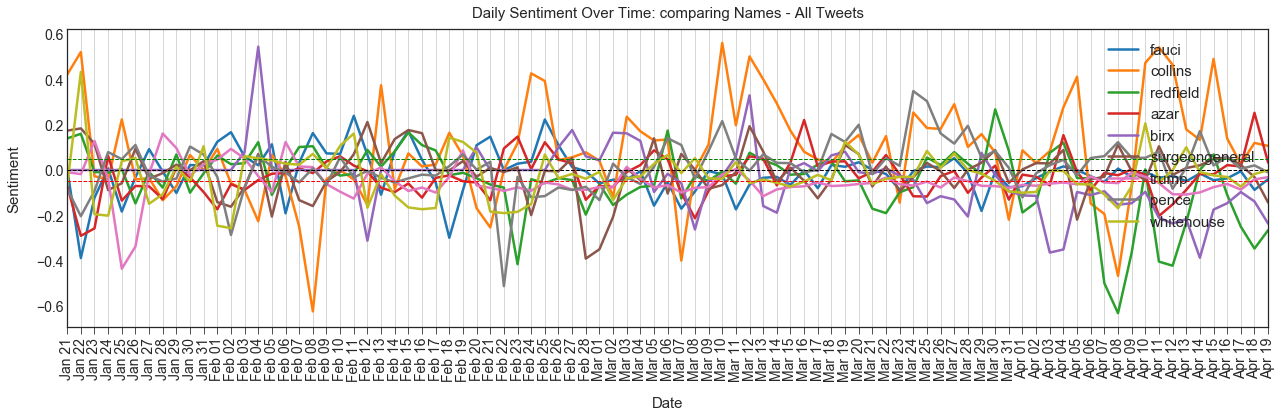

In [22]:
get_comparison_plot(df_names_intensity, df_names_sentiment, 'comparing Names - All Tweets')

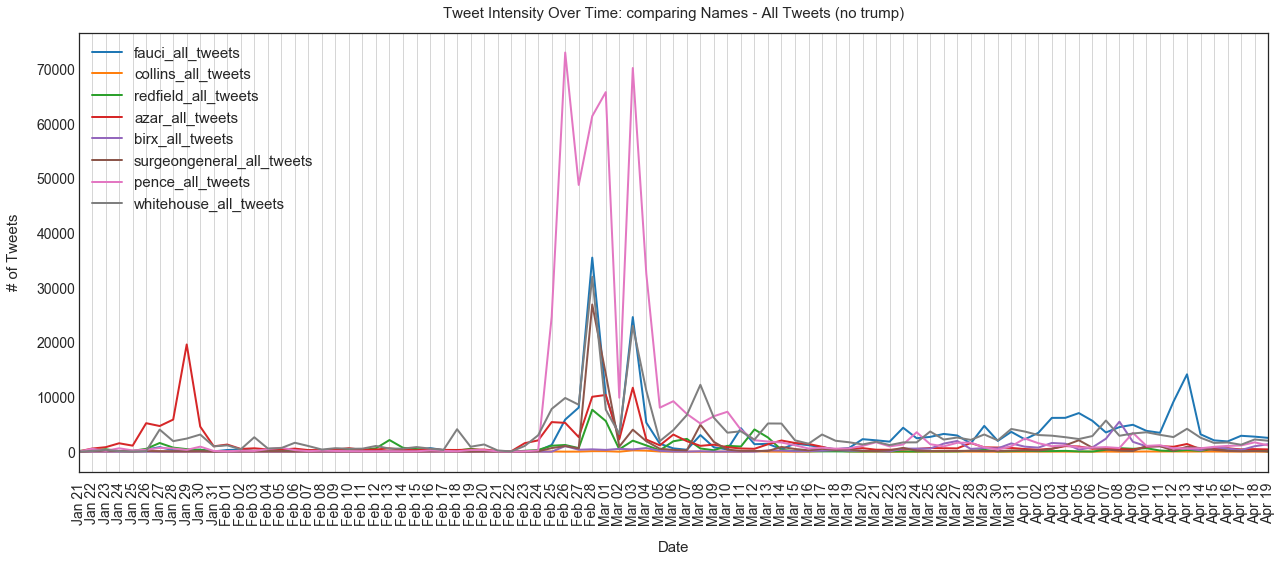

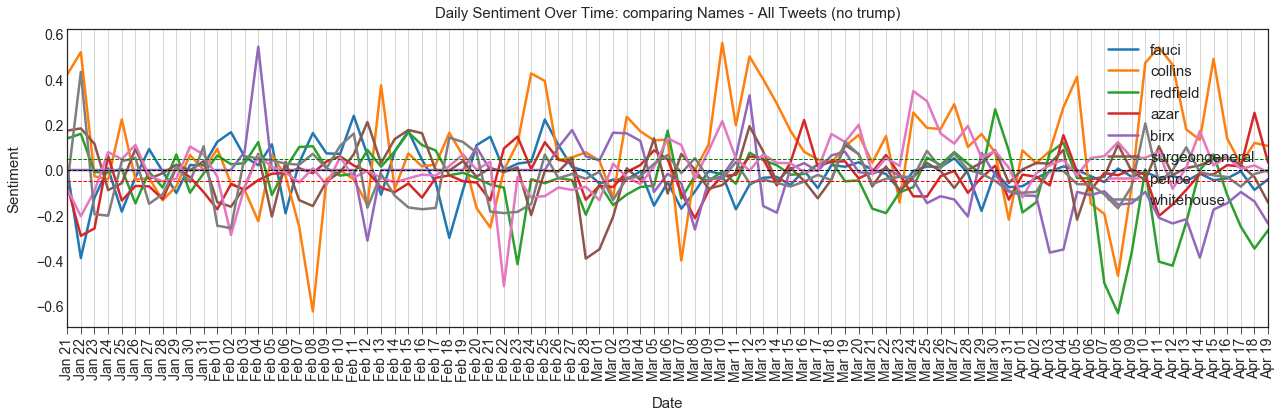

In [27]:
df_names_intensity.drop('trump_all_tweets', axis=1, inplace=True)
df_names_sentiment.drop('trump', axis=1, inplace=True)
get_comparison_plot(df_names_intensity, df_names_sentiment, 'comparing Names - All Tweets (no trump)')

# 4. Comparing (political) groupings

In [28]:
df_niaid_nih_intensity = pd.read_csv(INTENSITY_DIR + "niaid_nih_intensity_data.csv")
df_niaid_nih_fauci_collins_intensity = pd.read_csv(INTENSITY_DIR + "niaid_nih_fauci_collins_intensity_data.csv")
df_all_political_entities_intensity = pd.read_csv(INTENSITY_DIR + "all_political_entities_intensity_data.csv")
df_political_health_entities_intensity = pd.read_csv(INTENSITY_DIR + "political_health_entities_intensity_data.csv")

pol_intensity_names = ['niaid_nih', 'niaid_nih_fauci_collins', 'all_political_entities', 'political_health_entities']
pol_intensity_list = [df_niaid_nih_intensity, df_niaid_nih_fauci_collins_intensity, 
                      df_all_political_entities_intensity, df_political_health_entities_intensity]
# get_shape(pho_intensity_list)

df_niaid_nih_sentiment = pd.read_csv(SENTIMENT_DIR + "niaid_nih_sentiment_data.csv")
df_niaid_nih_fauci_collins_sentiment = pd.read_csv(SENTIMENT_DIR + "niaid_nih_fauci_collins_sentiment_data.csv")
df_all_political_entities_sentiment = pd.read_csv(SENTIMENT_DIR + "all_political_entities_sentiment_data.csv")
df_political_health_entities_sentiment = pd.read_csv(SENTIMENT_DIR + "political_health_entities_sentiment_data.csv")

pol_sentiment_names = ['niaid_nih', 'niaid_nih_fauci_collins', 'all_political_entities', 'political_health_entities']
pol_sentiment_list = [df_niaid_nih_sentiment, df_niaid_nih_fauci_collins_sentiment, 
                      df_all_political_entities_sentiment, df_political_health_entities_sentiment]

In [29]:
df_pol_intensity = merge_dfs(pol_intensity_list)
df_pol_intensity.fillna(0,  inplace=True)
pol_intensity_cols = get_col_name(pol_intensity_names)
df_pol_intensity.columns = pol_intensity_cols
print(df_pol_intensity.shape)

df_pol_sentiment = merge_dfs(pol_sentiment_list)
df_pol_sentiment.fillna(0,  inplace=True)
df_pol_sentiment.columns = ['date_EST'] + pol_sentiment_names
print(df_pol_sentiment.shape)

(90, 13)
(90, 5)


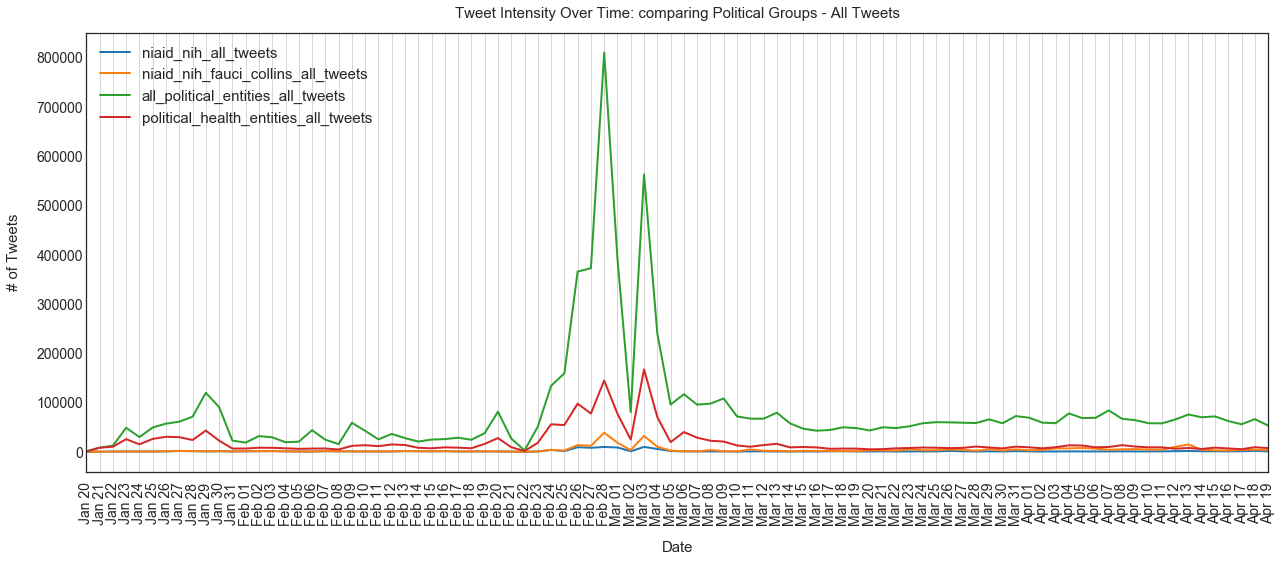

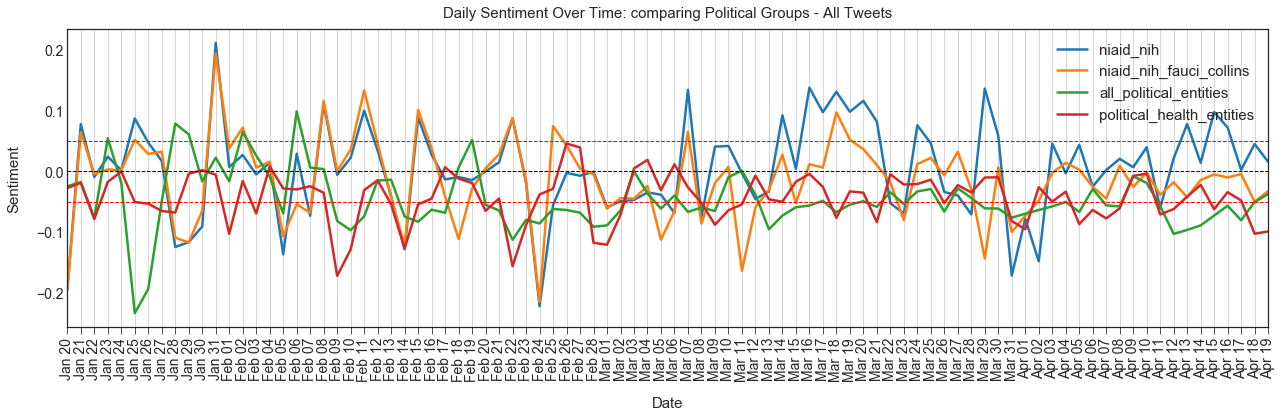

In [30]:
get_comparison_plot(df_pol_intensity, df_pol_sentiment, 'comparing Political Groups - All Tweets')

# END


# SANDBOX

### HOUR ROLLING

In [462]:
df_cdc_dailyhr = df_cdc[['datetime_EST','sent_comp']].copy()
df_cdc_dailyhr['datetime_EST'] = df_cdc_dailyhr['datetime_EST'].astype(str).str[:-9]
df_cdc_dailyhr['datetime_EST'] = pd.to_datetime(df_cdc_dailyhr['datetime_EST'])
df_cdc_dailyhr.set_index('datetime_EST', inplace=True)
df_cdc_dailyhr.columns = ['daily_hr_sentiment']
df_cdc_dailyhr = df_cdc_dailyhr.sort_index()
df_cdc_dailyhr.shape

(1437045, 1)

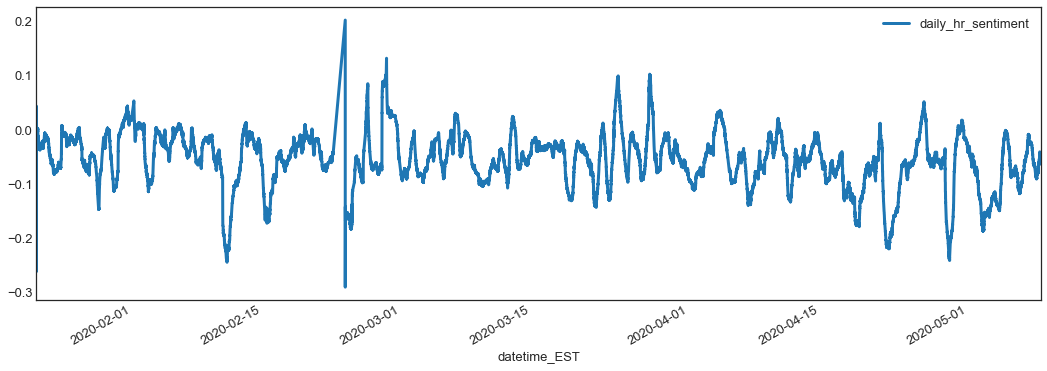

In [468]:
df_cdc_dailyhr.rolling('12H').mean().plot(figsize=(18, 6), linewidth=3.0)

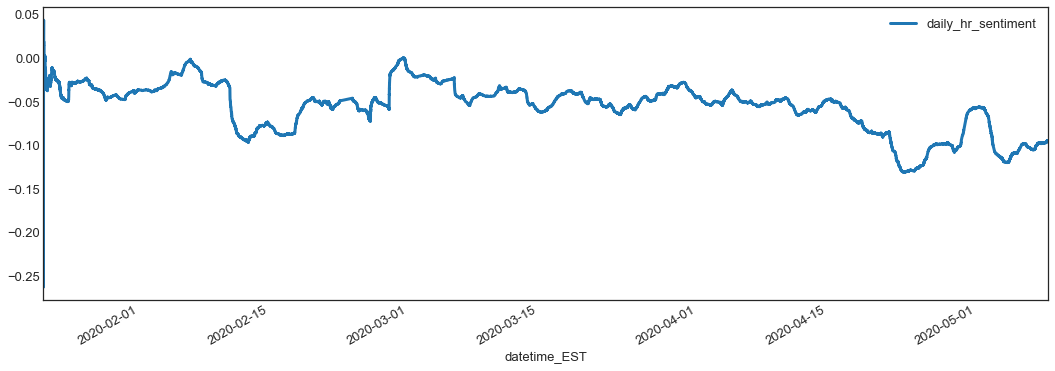

In [469]:
df_cdc_dailyhr.rolling('168H').mean().plot(figsize=(18, 6), linewidth=3.0)

In [465]:
def get_hr_rollingavg_plots(timeperiods, df_dailyavg):
    for i in timeperiods:
        df_dailyrolling = df_dailyavg.rolling(i).mean()
        df_dailyrolling.columns = ['hr_rolling_sentiment']
        mergedDf = df_dailyavg.merge(df_dailyrolling, left_index=True, right_index=True)
        print("done")

        linewidths = [2, 3]
        styles = ['--','-']
        fig, ax = plt.subplots(figsize=(18, 6))
        for col, style, lw in zip(mergedDf.columns, styles, linewidths):
            mergedDf[col].plot(style=style, lw=lw, ax=ax, rot=90)

        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.legend(loc=1, prop={'size': 15})
        plt.title("Hourly Sentiment - Moving Avg Timeperiod: " + str(i), y=1.02, fontsize=15)
        plt.show()